<p style="font-family: Arial; font-size:2.75em; font-style:bold; text-align:center"> Home Credit Default Risk

Notre travaille consiste à prédire dans quelle mesure chaque demandeur de prêt est capable de rembourser celui-ci. 

Nous avons commencé par une lecture des fichiers de 
données, une vérification des données manquantes, la
suppression des attributs qui ont un taux de valeurs
manquantes supérieure à 60% et le remplacement des autres
avec la méthode Imputer (most frequent), la visualisation de
la distribution de quelques variables y compris l’attribut
cible où 282686 valeurs sont à 0 qui veut dire que ces
contacteurs de prêts n’ont pas eu de problèmes pour
embourser et 24825 sont à 1.

On a ensuite on va procéder à la suppression des valeurs
aberrantes : dans l’attribut DAYS_EMPLOYED y’avait
plusieurs valeurs d’environ 1000 ans ce qui n’est pas
normal, on a listé les attributs les plus corrélées avec
l’attribut cible. 
On a ensuite on va traiter les variables catégorielles parce qu’un
modèle d'apprentissage automatique ne peut
malheureusement pas traiter ces variables à l'exception de
certains modèles tels que LightGBM. 


<h1 style="color:red">
Importation des Libraries

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.plotly import iplot

from sklearn.preprocessing import Imputer
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<h1 style="color:red"> Numerical EDA (Exploratory data analysis) 

Il existe un total de 9 fichiers: 1 fichier principal pour la formation (trainning) (avec TARGET), 1 fichier principal pour le test (sans TARGET), 1 exemple de fichier de soumission et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.


### 1) application_{train|test}.csv
<p>
   <ul>
   <li>C'est la table principale, divisée en deux fichiers Training (avec TARGET) et Test (sans TARGET).</li>
   <li>Une ligne représente un prêt dans notre échantillon de données.</li>
   </ul>
</p>

In [2]:
# Training data
app_train = pd.read_csv('../input/application_train.csv', sep=',')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [4]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [5]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

Training data contiennent 307511 observations (chacune constituant un prêt distinct) et 122 caractéristiques (variables), y compris TARGET (l'étiquette que nous voulons prédire).

In [7]:
#Testing data
app_test = pd.read_csv('../input/application_test.csv', sep=',')
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [9]:
app_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,...,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,-3051.712949,11.786027,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,2.146767,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.501180,0.518021,0.500106,0.122388,0.090065,0.978828,0.751137,0.047624,0.085168,0.151777,0.233706,0.238423,...,0.151200,0.233154,0.237846,0.068069,0.107063,0.113368,0.008979,0.029296,0.107129,1.447644,0.143652,1.435738,0.101139,-1077.766228,0.0,0.786620,0.000103,0.014751,0.087477,0.000041,0.088462,0.004493,0.0,0.001169,0.0,0.0,0.0,0.0,0.0,0.0,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,1569.276709,11.462889,0.004529,0.392526,0.403488,0.039971,0.440337,0.369046,0.890423,0.522694,0.515804,3.278172,0.135937,0.228306,0.200673,0.267332,0.417365,0.379299,0.205142,0.181278,0.189498,0.113112,0.081536,0.049318,0.113188,0.082868,0.139164,0.100669,0.147361,0.164976,...,0.100931,0.147629,0.165241,0.082869,0.099737,0.116503,0.048148,0.072998,0.111420,3.608053,0.514413,3.580125,0.403791,878.920740,0.0,0.409698,0.010128,0.120554,0.282536,0.006405,0.283969,0.066879,0.0,0.034176,0.0,0.0,0.0,0.0,0.0,0.0,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,

Les données de test sont generalement de taille plus petite (environ 30% de la totalité des données traning+test) et ne contient pas de colonne TARGET.

### 2) bureau.csv
<p>
   <ul>
   <li>Tous les crédits précédents de clients fournis par d'autres institutions financières qui ont été déclarés à Credit Bureau (pour les clients qui ont un prêt dans notre échantillon).</li>
   <li>Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait dans Credit Bureau avant la date de la demande.</li>
   </ul>
</p>

In [10]:
#Bureau data
bureau = pd.read_csv('../input/bureau.csv', sep=',')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [11]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


### 3) bureau_balance.csv
<p>
    <ul>
    <li>Soldes mensuels des crédits précédents dans Credit Bureau.</li>
   <li>Ce tableau contient une ligne pour chaque mois de chaque crédit précédent signalé à Credit Bureau - c-à-d cette table comporte (# prêts dans l’échantillon # de crédits précédents relatifs # de mois pour lesquels nous avons des antécédents observables pour les crédits précédents).</li>
   </ul>
</p>


In [12]:
#Bureau_balance data
bureau_bal = pd.read_csv('../input/bureau_balance.csv', sep=',')
bureau_bal .head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [13]:
bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


### 4) POS_CASH_balance.csv

  <p>
    <ul>
    <li>des snapshots du solde mensuel des précédents points de vente (POS) et des prêts en espèces que le demandeur avait contractés avec Home Credit.
</li>
   <li>Ce tableau contient une ligne pour chaque mois d’historique de tous les crédits précédents dans Home Credit (crédit à la consommation et prêts en espèces) liés aux prêts de notre échantillon - c-a-d que la table a (#prêts dans l’échantillon # de crédits précédents précédents # de mois dans lesquels nous avons des antécédents observables pour les crédits précédents) lignes.</li>
   </ul>
</p>



In [14]:
#POS_CASH_balance data
POS = pd.read_csv('../input/POS_CASH_balance.csv', sep=',')
POS.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [15]:
POS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


### 5) credit_card_balance.csv

<p>
    <ul>
    <li>snapshots du solde mensuel des anciennes cartes de crédit que le demandeur a avec Home Credit.</li>
    <li>Cette table contient une ligne pour chaque mois d’historique de tous les crédits précédents de Home Credit (crédit à la consommation et prêts en espèces) liés aux prêts de notre échantillon - c-a-d que la table a (#prêts dans l’échantillon # de cartes de crédit précédentes relatives # de mois où nous avons des antécédents observables pour les lignes précédentes de la carte de crédit.
    </li>
    </ul>
</p>


In [16]:
#credit_card_balance data
credit= pd.read_csv('../input/credit_card_balance.csv', sep=',')
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [17]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

### 6) previous_application.csv


<p>
   <ul>
   <li>Toutes les demandes précédentes de prêts de Home Credit des clients qui ont des prêts dans notre échantillon.</li>
   <li>Notre échantillon de données comporte une ligne pour chaque demande précédente liée aux prêts.</li>
   </ul>
</p>


In [18]:
#Applicant_Historique data
app_hist= pd.read_csv('../input/previous_application.csv', sep=',')
app_hist.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
app_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

### 7) installments_payments.csv

<p>
    <ul>
    <li> Historique de remboursement des crédits précédemment décaissés dans Home Credit liés aux prêts de notre échantillon</li>
     <li>Il y a: <br>
     a) une ligne pour chaque paiement effectué<br> 
     b) une ligne pour chaque paiement manqué.
    </li>
    <li>  Une rangée équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.
</li>
   </ul>
</p>



In [20]:
#installments_payments data
pmt= pd.read_csv('../input/installments_payments.csv', sep=',')
pmt.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [21]:
pmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


<h1 style="color:red">Shape des données

In [22]:
print('Size of application_train data', app_train.shape)
print('Size of application_test data', app_test.shape)
print('Size of bureau data', bureau.shape)
print('Size of bureau_balance data', bureau_bal.shape)
print('Size of previous_application data', app_hist.shape)
print('Size of POS_CASH_balance data', POS.shape)
print('Size of installments_payments data', pmt.shape)
print('Size of credit_card_balance data', credit.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of bureau data (1716428, 17)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of POS_CASH_balance data (10001358, 8)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)


<h1 style="color:red">Vérification des données manquantes


On devra compléter ces valeurs manquantes. On utilisera par exemple des modèles tels que XGBoost, capables de traiter les valeurs manquantes sans imputation. Une autre option consisterait à supprimer les colonnes contenant un pourcentage élevé de valeurs manquantes, mais on sait pas maintenant si ces colonnes seront utiles à notre modèle. On va conservrer toutes les colonnes pour le moment.

** Vérifier les données manquantes dans application_train**


In [23]:
# checking missing data
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


Text(0.5,1,'Percent missing data "Training Data"')

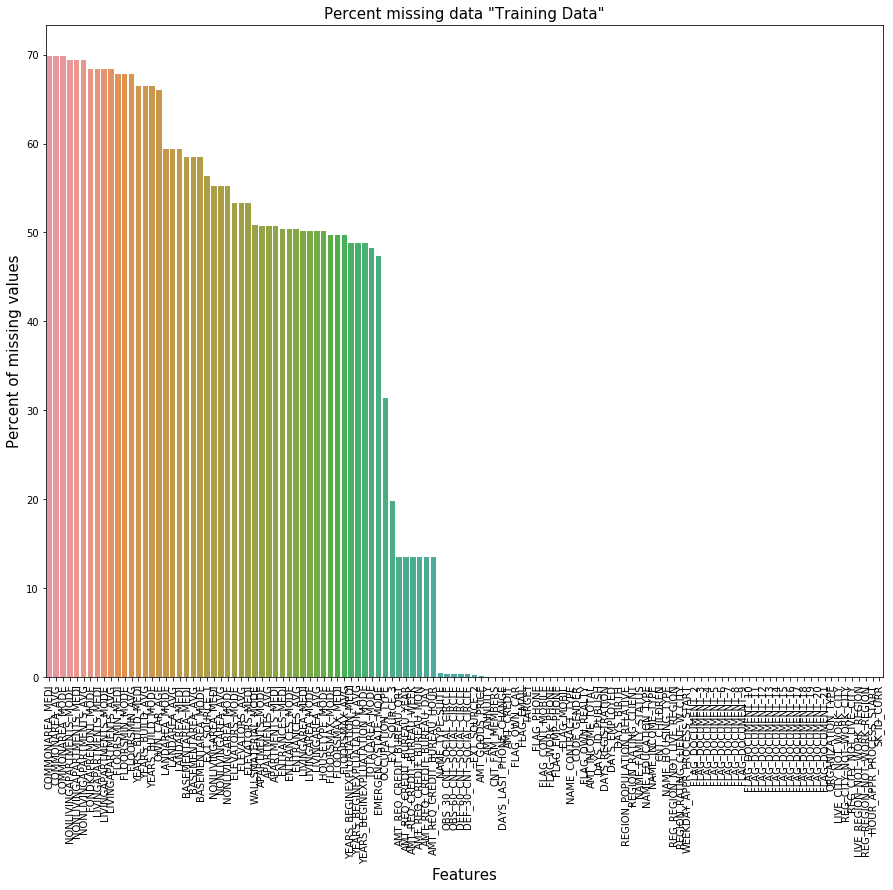

In [24]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_app_train_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data "Training Data"', fontsize=15)


** Vérifier les données manquantes dans application_test**


In [25]:
# checking missing data
total = app_test.isnull().sum().sort_values(ascending = False)
percent = (app_test.isnull().sum()/app_test.isnull().count()*100).sort_values(ascending = False)
missing_app_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_test_data.head(10)

,Total,Percent
COMMONAREA_MEDI,33495,68.716150
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
NONLIVINGAPARTMENTS_AVG,33347,68.412523
FONDKAPREMONT_MODE,32797,67.284179
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302
LIVINGAPARTMENTS_MODE,32780,67.249302


Text(0.5,1,'Percent missing data "Test Data"')

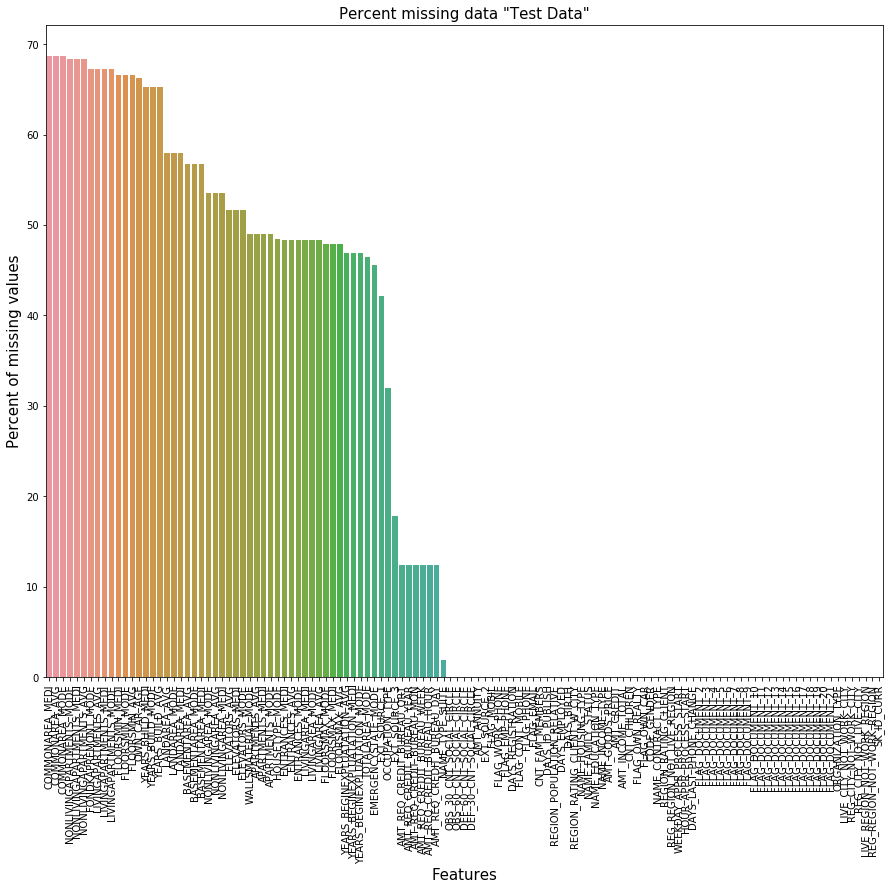

In [26]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_app_test_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data "Test Data"', fontsize=15)


** Vérifier les données manquantes dans  bureau  **


In [27]:
# checking missing data
total = bureau.isnull().sum().sort_values(ascending = False)
percent = (bureau.isnull().sum()/bureau.isnull().count()*100).sort_values(ascending = False)
missing_bureau_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_data.head(8)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_TYPE,0,0.000000


Text(0.5,1,'Percent missing data by feature "Bureau"')

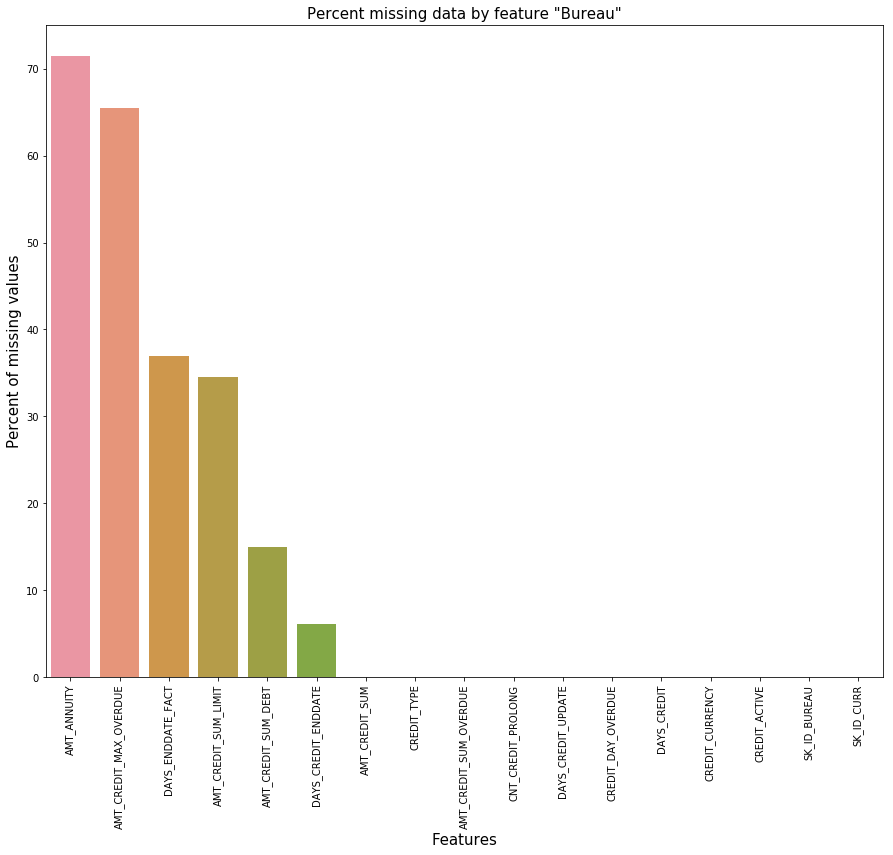

In [28]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_bureau_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature "Bureau"', fontsize=15)


** Vérifier les données manquantes dans POS_CASH_balance **


In [29]:
# checking missing data
total = POS.isnull().sum().sort_values(ascending = False)
percent = (POS.isnull().sum()/POS.isnull().count()*100).sort_values(ascending = False)
missing_POS_CASH_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_POS_CASH_balance_data.head(3)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_DPD_DEF,0,0.000000


Text(0.5,1,'Percent missing data by feature "POS_CASH_balance"')

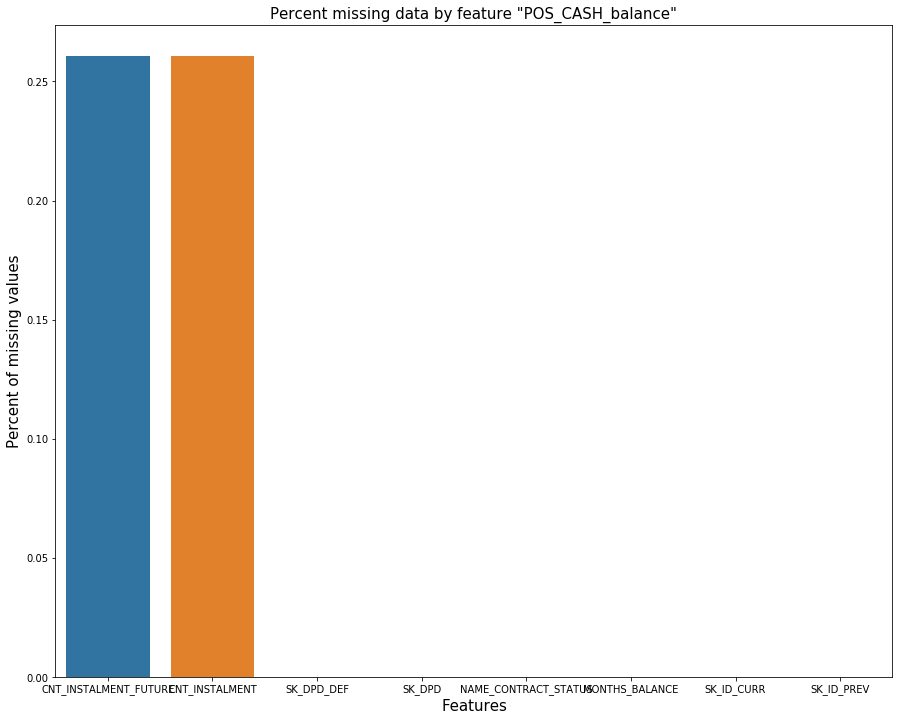

In [30]:
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(x=missing_POS_CASH_balance_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature "POS_CASH_balance"', fontsize=15)

** Vérifier les données manquantes dans bureau_balance **


In [31]:
# checking missing data
total = bureau_bal.isnull().sum().sort_values(ascending = False)
percent = (bureau_bal.isnull().sum()/bureau_bal.isnull().count()*100).sort_values(ascending = False)
missing_bureau_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_balance_data.head(3)

,Total,Percent
STATUS,0,0.0
MONTHS_BALANCE,0,0.0
SK_ID_BUREAU,0,0.0


** Vérifier les données manquantes dans previous_application  **


In [32]:
# checking missing data
total = app_hist.isnull().sum().sort_values(ascending = False)
percent = (app_hist.isnull().sum()/app_hist.isnull().count()*100).sort_values(ascending = False)
missing_previous_app_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_previous_app_data.head(17)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129


Text(0.5,1,'Percent missing data by feature "Bureau Balance"')

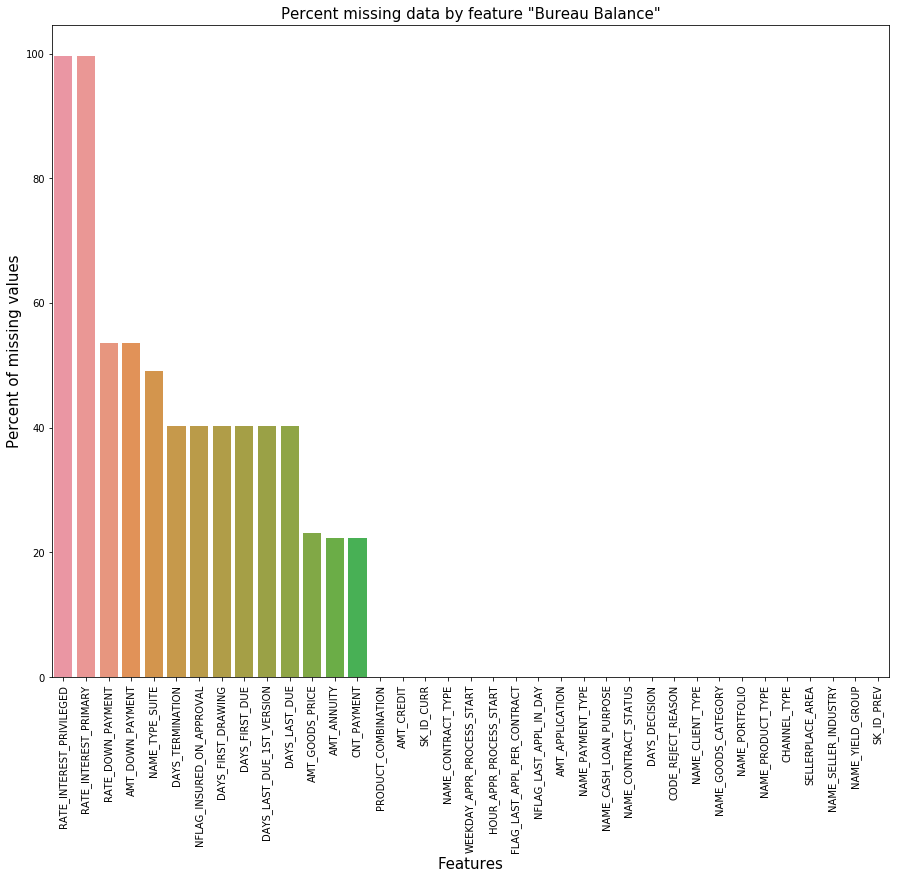

In [33]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_previous_app_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature "Bureau Balance"', fontsize=15)


** Vérifier les données manquantes dans  installments_payments  **


In [34]:
# checking missing data
total = pmt.isnull().sum().sort_values(ascending = False)
percent = (pmt.isnull().sum()/pmt.isnull().count()*100).sort_values(ascending = False)
missing_installments_payments_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_installments_payments_data.head(3)

,Total,Percent
AMT_PAYMENT,2905,0.021352
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_INSTALMENT,0,0.000000


Text(0.5,1,'Percent missing data by feature "Installments payments" ')

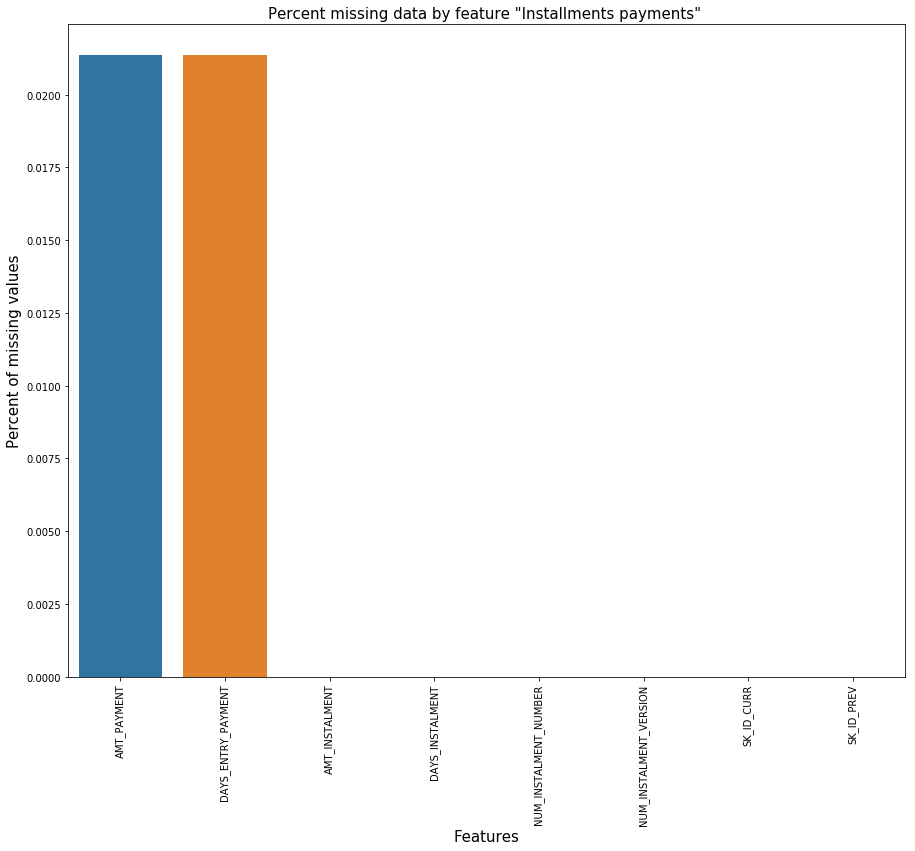

In [35]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_installments_payments_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature "Installments payments" ', fontsize=15)


** Vérifier les données manquantes dans credit_card_balance  **


In [36]:
# checking missing data
total = credit.isnull().sum().sort_values(ascending = False)
percent = (credit.isnull().sum()/credit.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_credit_card_balance_data.head(10)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_DPD_DEF,0,0.000000


Text(0.5,1,'Percent missing data by feature "Credit card balance" ')

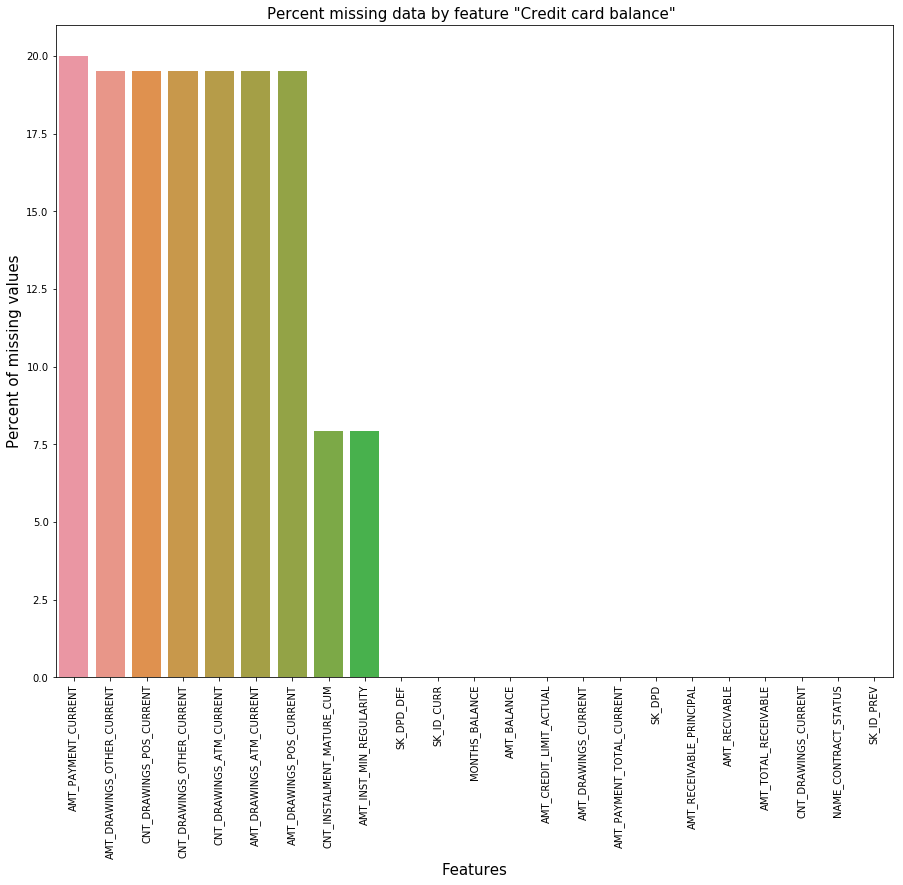

In [37]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_credit_card_balance_data.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature "Credit card balance" ', fontsize=15)


<h1 style="color:red">Visual EDA

<h3 style="color:green"> 1- Distribution de AMT_CREDIT</h3>

Montrons la distribution du crédit.

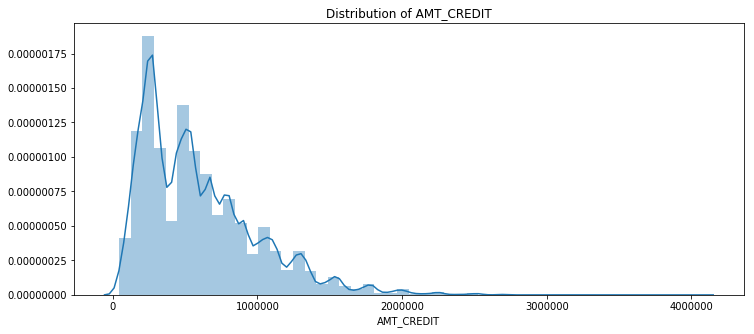

In [38]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(app_train["AMT_CREDIT"])

<h3 style="color:green"> 2- Distribution de AMT_INCOME_TOTAL

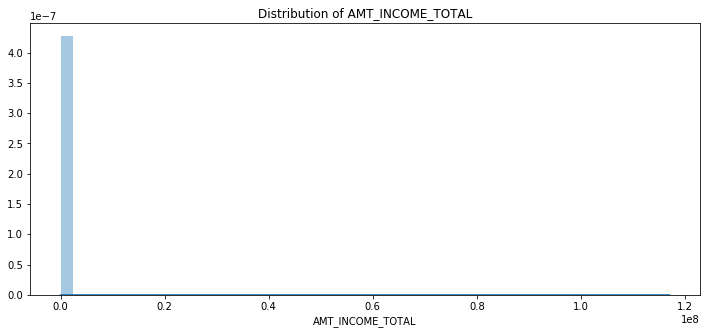

In [39]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(app_train["AMT_INCOME_TOTAL"])

<h3 style="color:green"> 3- Distribution de AMT_GOODS_PRICE</h3>

Montrons la bonne distribution des prix.

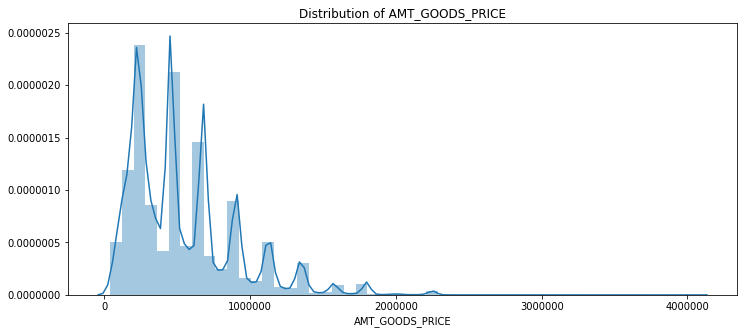

In [40]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(app_train["AMT_GOODS_PRICE"].dropna())#.dropna() pour sup Nan

<h3 style="color:green">4- Types of Organizations who applied for loan 


In [41]:
temp = app_train["ORGANIZATION_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values,
                   '%':temp.values/temp.values.sum(),
                  })
df

,labels,values,%
0,Business Entity Type 3,67992,0.221104
1,XNA,55374,0.180072
2,Self-employed,38412,0.124913
3,Other,16683,0.054252
4,Medicine,11193,0.036399
5,Business Entity Type 2,10553,0.034317
6,Government,10404,0.033833
7,School,8893,0.028919
8,Trade: type 7,7831,0.025466
9,Kindergarten,6880,0.022373


Types of Organizations who applied for loan :
        - Business Entity Type 3 - Approx. 68 K
        XNA - Approx. 55 K
        Self employed - Approx. 38 K
        Others - Approx. 17 K
        Medicine - Approx. 11 K

<h3 style="color:green"> 5- Les données sont équilibrées ou déséquilibrées


<p>L'objectif est ce que l'on nous demande de prédire:
<li> soit un 0 pour le prêt a été remboursé à temps</li>
<li>soit un 1 indiquant que le client avait des difficultés de paiement.</li>
Nous pouvons d’abord examiner le nombre de prêts entrant dans chaque catégorie.</p>

In [42]:
temp = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values})
df

,labels,values
0,0,282686
1,1,24825


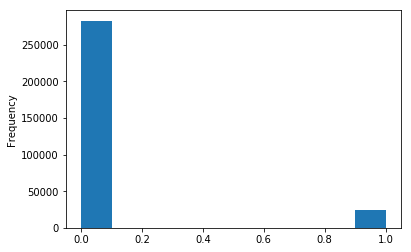

In [43]:
app_train['TARGET'].astype(int).plot.hist();
plt.show()

D'après ce histogramme, nous remarquons qu'il s'agit d'un problème de classe déséquilibré. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. 

<h3 style="color:green"> 6- Types de prêt</h3>


Voyons le type de prêts contractés et également, le pourcentage de prêts (par type de prêt) ayant pour valeur TARGET 1 (prêt non remboursé).

In [44]:
temp = app_train["NAME_CONTRACT_TYPE"].value_counts()
temp

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [45]:
temp = app_train["NAME_CONTRACT_TYPE"].value_counts('Cash loans')
temp

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64

La plupart des prêts sont des prêts en espèces qui ont été contractés par les candidats. Les prêts à 90,5% sont des prêts de trésorerie.

<h3 style="color:green"> 7- Objet du prêt

In [46]:
temp1 = app_train["FLAG_OWN_CAR"].value_counts()
temp2 = app_train["FLAG_OWN_REALTY"].value_counts()
print(temp1, temp2)


N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64 Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


In [47]:
temp1 = app_train["FLAG_OWN_CAR"].value_counts('N')
temp2 = app_train["FLAG_OWN_REALTY"].value_counts('N')
print(temp1)
print(temp2)

N    0.659892
Y    0.340108
Name: FLAG_OWN_CAR, dtype: float64
Y    0.693673
N    0.306327
Name: FLAG_OWN_REALTY, dtype: float64


<h3 style="color:green"> 8- Sources de revenus du demandeur qui a demandé un prêt</h3>

Examinons le nombre de clients avec différents types de revenus. 

In [48]:
temp = app_train["NAME_INCOME_TYPE"].value_counts()#NAME_CONTRACT_TYPE
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df

,labels,values
0,Working,158774
1,Commercial associate,71617
2,Pensioner,55362
3,State servant,21703
4,Unemployed,22
5,Student,18
6,Businessman,10
7,Maternity leave,5


La plupart des demandeurs de prêts sont des workers, suivis des associés commerciaux, retraités et agents de l'État.

<h3 style="color:green"> 9- Situation familiale du demandeur d'un prêt

In [49]:
temp = app_train["NAME_FAMILY_STATUS"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df

,labels,values
0,Married,196432
1,Single / not married,45444
2,Civil marriage,29775
3,Separated,19770
4,Widow,16088
5,Unknown,2


La plupart des clients sont mariés, suivis du célibataire/non marié et civil.

En termes de pourcentage de non remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non remboursement (10%), Veuve étant le plus faible (exception inconnue).

<h4 style="color:green"> Effect of Age on Repayment

In [50]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694


À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie que plus le client vieillit, plus il a tendance à rembourser ses emprunts à temps.

Commençons par regarder cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. Nous mettrons l’axe des x dans des années pour rendre l’intrigue un peu plus compréhensible.

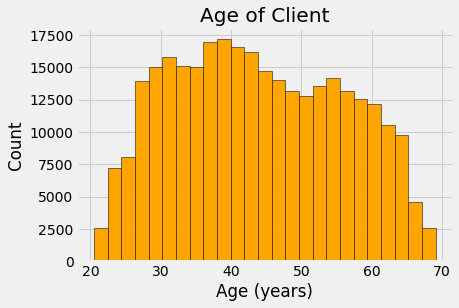

In [51]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25, color='orange')
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.show()

La répartition de l’âge ne nous dit pas grand chose, on remarque qu’il n’y a pas de valeurs aberrantes, car tous les âges sont raisonnables. <br>
Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite créer un graphe KDE (Kernel Density Plot), coloré par la valeur de la cible. Un graphique d’estimation de la densité du noyau indique la distribution d’une variable unique et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer un seul noyau lisse. courbe). Nous allons utiliser le kdeplot Seaborn pour ce graphique.

<h3 style="color:green"> 10- Occupation of Applicant's who applied for loan


In [52]:
temp = app_train["OCCUPATION_TYPE"].value_counts()
temp

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64



    Top Applicant's who applied for loan :
        Laborers - Apprx. 55 K
        Sales Staff - Approx. 32 K
        Core staff - Approx. 28 K
        Managers - Approx. 21 K
        Drivers - Approx. 19 K



<h3 style="color:green"> 11- Education of Applicant's who applied for loan


In [53]:
temp = app_train["NAME_EDUCATION_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values,
                   '%':temp.values/temp.values.sum(),
                  })
df

,labels,values,%
0,Secondary / secondary special,218391,0.710189
1,Higher education,74863,0.243448
2,Incomplete higher,10277,0.033420
3,Lower secondary,3816,0.012409
4,Academic degree,164,0.000533


71 % applicants have secondary and 24.3 % having higher education.

<h3 style="color:green"> 12 For which types of house higher applicant's applied for loan ?


In [54]:
temp = app_train["NAME_HOUSING_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values,
                   '%':temp.values/temp.values.sum(),
                  })
df

,labels,values,%
0,House / apartment,272868,0.887344
1,With parents,14840,0.048258
2,Municipal apartment,11183,0.036366
3,Rented apartment,4881,0.015873
4,Office apartment,2617,0.008510
5,Co-op apartment,1122,0.003649




    Approx. 89 % peoples applied for loan, they mentioned type of house is House / Appartment.



<h3 style="color:green">   Les anomalies </h3>

Un problème que nous voulons toujours surveiller lorsque nous effectuons une EDA est le fait qu'il ait des anomalies présentes dans les données. Celles-ci peuvent être dues à des chiffres mal typés, à des erreurs d’équipement de mesure ou peuvent être des mesures valables mais extrêmes. Une façon de vérifier quantitativement les anomalies consiste à consulter les statistiques d'une colonne à l'aide de la méthode describe. 

Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours de l'année:

In [55]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

Ces données semblent normales. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit dans le haut ou le bas. <br>
On vérifie maintenant l'attribut DAYS_EMPLOYED que représente les jours d'emploi

In [56]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La valeur maximale est d'environ 1000 ans et positive

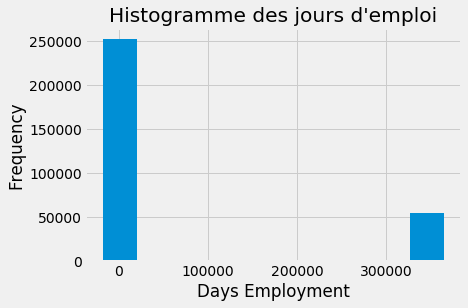

In [57]:
app_train['DAYS_EMPLOYED'].plot.hist(title = "Histogramme des jours d'emploi");
plt.xlabel('Days Employment');
plt.show()

Les clients anormaux ont des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [58]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


On remarque que les anomalies ont un taux bas de défaut.<br>
Le traitement des anomalies dépend de la situation exacte, sans règles définies. L'une des approches les plus sûres consiste simplement à définir les anomalies sur une valeur manquante, puis à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, étant donné que toutes les anomalies ont exactement la même valeur, nous souhaitons les remplir avec la même valeur au cas où tous ces prêts partageraient un élément commun. Les valeurs anormales semblent avoir une certaine importance, nous voulons donc indiquer le modèle d’apprentissage automatique si nous avons bien renseigné ces valeurs. En guise de solution, nous allons renseigner les valeurs anormales avec pas un nombre (np.nan), puis créer une nouvelle colonne booléenne indiquant si la valeur est anormale ou non.

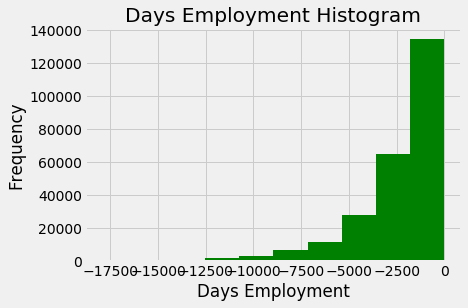

In [59]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram',color='green');
plt.xlabel('Days Employment');
plt.show()

La distribution semble être beaucoup plus conforme à ce à quoi nous nous attendions, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient initialement anormales de la colonne). Les autres colonnes avec DAYS dans le cadre de données semblent indiquer ce à quoi nous nous attendons, sans aberrations évidentes.

Il est extrêmement important de noter que tout ce que nous faisons vis-à-vis des données de formation doit également être appliqué aux données de test. Faisons en sorte de créer la nouvelle colonne et de remplir la colonne existante avec np.nan dans les données de test.

In [60]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print("Il y'a %d anomalies dans les données de test parmis %d entrées" % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Il y'a 9274 anomalies dans les données de test parmis 48744 entrées


<h1 style="color:red"> Corrélation Pearson des fonctionnalités

### Les corrélations
Apres avoir traité les variables catégorielles et les valeurs aberrantes, on continue l'exploration de données. Une façon d'essayer de comprendre les données consiste à rechercher des corrélations entre les caractéristiques et la cible. <br>
Nous pouvons calculer le coefficient de corrélation entre chaque variable et la cible à l’aide de la méthode .corr qu'on peut appliquer à un dataframe.<br>
Le coefficient de corrélation n'est pas la méthode la plus efficace pour représenter la "pertinence" d'une entité, mais il nous donne une idée des relations possibles au sein des données. <br>
Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation:<br>

<li>0,00 à 0,1  ==> très faible</li>
<li>0,20 à 0,39 ==> faible</li>
<li>0,40 à 0,59 ==> modéré</li>
<li>0,60 à 0,79 ==> fort</li>
<li>0,80 à 1,0  ==> très fort</li>

In [61]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_BIRTH                   -0.078239
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226



###### Les corrélations les plus significatives: 
DAYS_BIRTH est la corrélation la plus positive à part TARGET car la corrélation d'une variable avec elle-même est toujours égale à 1.<br>
En regardant la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt toujours négatifs quelle qu'en soit la raison.<br>
La corrélation est positive, mais la valeur de cet attribut est en réalité négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (TARGET == 0).<br>
Nous allons donc prendre la valeur absolue de l'entité et ensuite la corrélation sera négative pour obtenir un résultat plus logique.

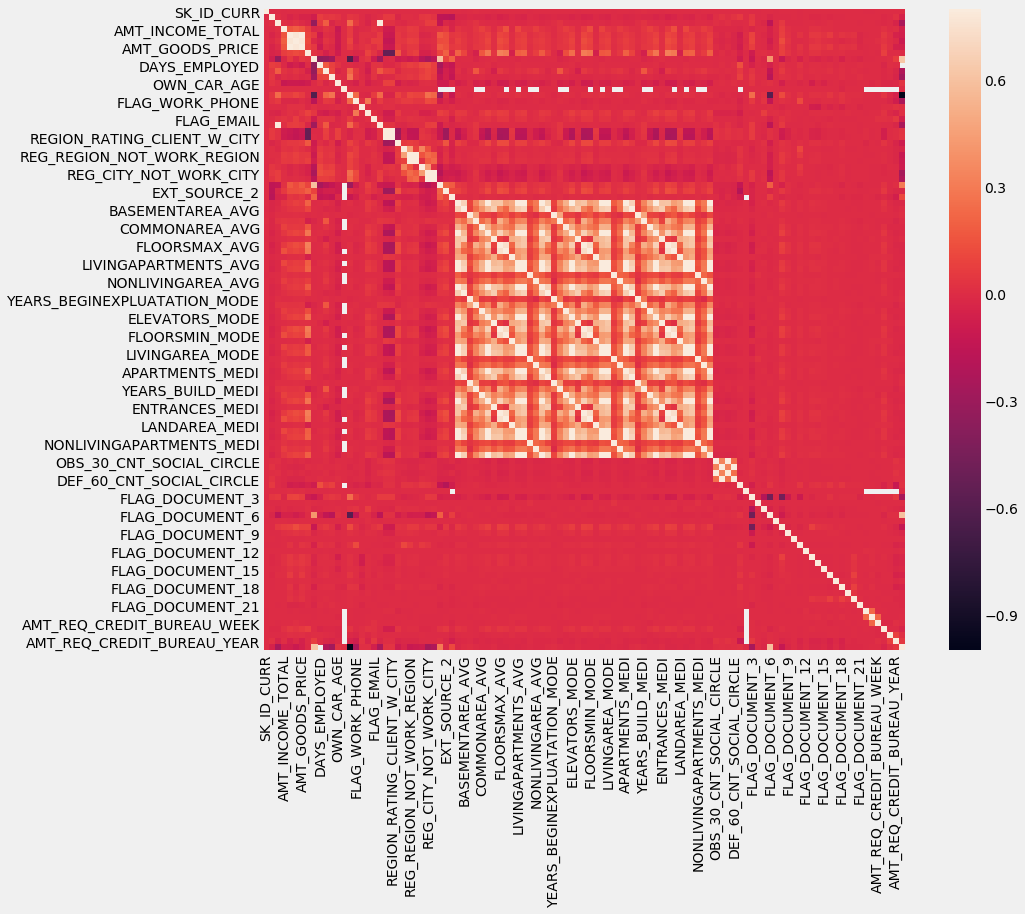

In [62]:
#correlation matrix
corrmat = app_train.corr()
f, ax = plt.subplots(figsize=(14, 11))#12, 9
sns.heatmap(corrmat, vmax=.8, square=True);

On va devoir traiter des variables catégorielles. Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM). On doit alors trouver un moyen pour représenter ces variables sous forme de nombres avant de les transférer au modèle. Il y a deux manières principales de mener à bien ce processus:<br>
#### 1 - Label encoding: 
On assigne chaque catégorie unique dans une variable catégorielle avec un entier. (Aucune nouvelle colonne n'est créée).

In [63]:
# Créer un objet label encoder 
le = LabelEncoder()
count = 0

# parcourir les attributs de app_train
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            count += 1
            
print('%d columns were label encoded.' % count)

3 columns were label encoded.


#### 2 - One-hot encoding:
On crée une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne pour la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

In [64]:
# one-hot encoding des variables catégorielles
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training data shape: ', app_train.shape)
print('Testing data shape: ', app_test.shape)

Training data shape:  (307511, 244)
Testing data shape:  (48744, 240)


<h1 style="color:red"> Traitemant des valeurs manquantes

### Pour les données d'entraînement

In [65]:
# checking missing data
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
FLOORSMIN_MODE,208642,67.848630


#### On va supprimer les features qui ont un pourcentage de missing value superieur a 60%.

In [66]:
#16
features=app_train[['COMMONAREA_MEDI','COMMONAREA_MODE','COMMONAREA_AVG','NONLIVINGAPARTMENTS_MEDI',
          'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_MODE',
         'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI','FLOORSMIN_AVG','FLOORSMIN_MODE',
          'FLOORSMIN_MEDI','YEARS_BUILD_MODE','YEARS_BUILD_MEDI','YEARS_BUILD_AVG','OWN_CAR_AGE']]


In [67]:
app_train=app_train.drop(features,axis=1)

In [68]:
#Training data shape:  (307511, 245)
app_train.shape

(307511, 228)

#### Maintenant on va remplacer les missing values des autres attributes avec la methode "Imputer" et strategy='most_frequent'

In [69]:
#valeurs manquantes 
columns=app_train.columns
ind=app_train.index
fill_NaN = Imputer(missing_values=np.nan, strategy='most_frequent', axis=1)
app_train= pd.DataFrame(fill_NaN.fit_transform(app_train))
app_train.columns = columns
app_train.index = ind

In [70]:
# checking missing data
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_train_data.head()

,Total,Percent
EMERGENCYSTATE_MODE_Yes,0,0.0
FLAG_DOCUMENT_19,0,0.0
FLAG_DOCUMENT_17,0,0.0
FLAG_DOCUMENT_16,0,0.0
FLAG_DOCUMENT_15,0,0.0


On a plus de valeurs manquantes.

### Pour les données de test

In [71]:
# checking missing data (64)
total = app_test.isnull().sum().sort_values(ascending = False)
percent = (app_test.isnull().sum()/app_test.isnull().count()*100).sort_values(ascending = False)
missing_app_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_test_data.head(20)

,Total,Percent
COMMONAREA_MODE,33495,68.716150
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
NONLIVINGAPARTMENTS_AVG,33347,68.412523
LIVINGAPARTMENTS_MODE,32780,67.249302
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302
FLOORSMIN_MEDI,32466,66.605121


#### On va supprimer les features qui ont un pourcentage de missing value superieur a 60%.

In [72]:
#16
features=app_test[['COMMONAREA_MEDI','COMMONAREA_MODE','COMMONAREA_AVG','NONLIVINGAPARTMENTS_MEDI',
          'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_MODE',
         'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI','FLOORSMIN_AVG','FLOORSMIN_MODE',
          'FLOORSMIN_MEDI','YEARS_BUILD_MODE','YEARS_BUILD_MEDI','YEARS_BUILD_AVG','OWN_CAR_AGE']]


In [73]:
app_test=app_test.drop(features,axis=1)

In [74]:
#Training data shape:  (307511, 245)
app_test.shape

(48744, 224)

#### Maintenant on va remplacer les missing values des autres attributes avec la methode "Imputer" et strategy='most_frequent'

In [75]:
#valeurs manquantes 
columns=app_test.columns
ind=app_test.index
fill_NaN = Imputer(missing_values=np.nan, strategy='most_frequent', axis=1)
app_test= pd.DataFrame(fill_NaN.fit_transform(app_test))
app_test.columns = columns
app_test.index = ind

In [76]:
# checking missing data
total = app_test.isnull().sum().sort_values(ascending = False)
percent = (app_test.isnull().sum()/app_test.isnull().count()*100).sort_values(ascending = False)
missing_application_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_test_data.head()

,Total,Percent
EMERGENCYSTATE_MODE_Yes,0,0.0
EMERGENCYSTATE_MODE_No,0,0.0
FLAG_DOCUMENT_17,0,0.0
FLAG_DOCUMENT_16,0,0.0
FLAG_DOCUMENT_15,0,0.0


On a plus de valeurs manquantes.

<h1 style="color:red">Application des modèles

In [77]:
# Import necessary modules
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
# Import EarlyStopping
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
import sklearn.neighbors as nb
import sklearn.neighbors as  KNeighborsClassifier
from sklearn import linear_model
from sklearn.neighbors.nearest_centroid import NearestCentroid
import sklearn.model_selection as ms
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import  recall_score, precision_score, accuracy_score
from sklearn.linear_model import RidgeClassifier, Lasso,LogisticRegression
from mlxtend.classifier import StackingClassifier
import xgboost
from sklearn import metrics, model_selection
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

Using TensorFlow backend.


## Alignement de données de Training et de Test
Les mêmes attributs (colonnes) doivent figurer dans les données de training et de test. One-hot encoding a créé plus de colonnes dans les données d'apprentissage que dans les données de test, car certaines variables catégorielles avaient des catégories non représentées dans les données de test. Pour supprimer les attributs des données d'apprentissage qui ne figurent pas dans les données de test, On doit aligner les dataframes. <br>
Premièrement, nous allons extraire la colonne cible des données d'apprentissage (car elle ne figure pas dans les données de test, mais on va conserver ces données). Lorsque nous faisons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les dataframes en fonction des colonnes et non des lignes!

In [78]:
# On stock la colonne TARGET dans la variable train_labels
train_labels = app_train['TARGET']

# On aligne les données de training et de test , On garde que els colonnes présentent dans les deux dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 225)
Testing Features shape:  (48744, 224)


In [79]:
y = app_train["TARGET"]
X = app_train.drop('TARGET', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h1 style="color:green;">1- K-Nearest Neighbors (K-NN)  </h1>

In [80]:
#create KNN classifier object by passing argument number of neighbors in KNeighborsClassifier() function.
knn = nb.KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [81]:
y_predKnn = knn.predict(X_test)
y_predKnn 

array([0., 0., 1., ..., 0., 0., 0.])

In [82]:
acc_knn = accuracy_score(y_test, y_predKnn)
print("Accuracy:", acc_knn)

Accuracy: 0.9026817265376027


In [83]:
precision_knn= precision_score(y_test,y_predKnn)
recall_knn = recall_score(y_test, y_predKnn)

# f_mesure
F_knn = 2 * (precision_knn* recall_knn) / (precision_knn + recall_knn)
F_knn

0.05255382017729

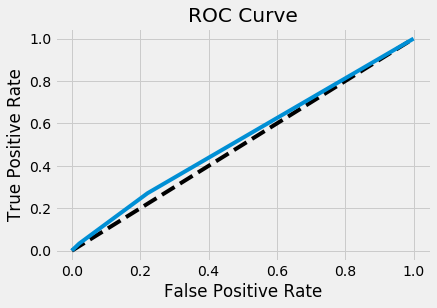

In [84]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;"> 2- DecisionTreeClassifier 

In [85]:
xgbt = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
xgbt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [86]:
y_predDT = xgbt.predict(X_test)
y_predDT

array([0., 0., 0., ..., 0., 0., 0.])

In [87]:
acc_DT = accuracy_score(y_test, y_predDT)
acc_DT

0.9196457606174258

In [88]:
precision_DT = precision_score(y_test,y_predDT)
recall_DT = recall_score(y_test, y_predDT)

# f_mesure
F_DT = 2 * (precision_DT * recall_DT) / (precision_DT + recall_DT)
F_DT

nan

In [89]:
roc_auc_score(y_test, y_predDT)

0.5

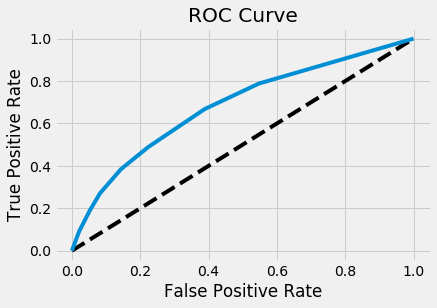

In [90]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = xgbt.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">3- K-centroide</h1>

In [91]:
model_centroide = NearestCentroid()
model_centroide.fit(X_train, y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [92]:
y_predCentroide=model_centroide.predict(X_test)
y_predCentroide

array([1., 0., 1., ..., 1., 1., 1.])

In [93]:
acc_KC = accuracy_score(y_test, y_predCentroide)
acc_KC

0.4270600732759555

In [94]:
precision_KC = precision_score(y_test,y_predCentroide)
recall_KC = recall_score(y_test, y_predCentroide)

# f_mesure
F_KC = 2 * (precision_KC * recall_KC) / (precision_KC + recall_KC)
F_KC

0.15670570216024765

In [95]:
roc_auc_score(y_test, y_predCentroide)

0.5344873053677655

<h1 style="color:green;">4- Ridge  </h1>

In [96]:
ridge = RidgeClassifier(alpha=41, max_iter=50000)
ridge.fit(X_train, y_train)

RidgeClassifier(alpha=41, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=50000, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [97]:
y_predridge = ridge.predict(X_test)
y_predridge

array([0., 0., 0., ..., 0., 0., 0.])

In [98]:
acc_ridge= accuracy_score(y_test, y_predridge)
acc_ridge

0.9196566002558154

In [99]:
precision_ridge = precision_score(y_test,y_predridge)
recall_ridge = recall_score(y_test, y_predridge)

# f_mesure
F_ridge = 2 * (precision_ridge * recall_ridge) / (precision_ridge + recall_ridge)
F_ridge

0.0002697599136768276

In [100]:
roc_auc_score(y_test, y_predridge)

0.5000674490759477

<h1 style="color:green;">5- Neural Network: MLPClassifier </h1>

In [101]:
# MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
MLP.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [102]:
y_predMLP = MLP.predict(X_test)
y_predMLP

array([0., 0., 0., ..., 1., 0., 1.])

In [103]:
acc_MLP= accuracy_score(y_test, y_predMLP)
acc_MLP

0.8611117133132439

In [104]:
precision_MLP = precision_score(y_test,y_predMLP)
recall_MLP = recall_score(y_test, y_predMLP)

# f_mesure
F_MLP = 2 * (precision_MLP * recall_MLP) / (precision_MLP + recall_MLP)
F_MLP

0.06371940080379979

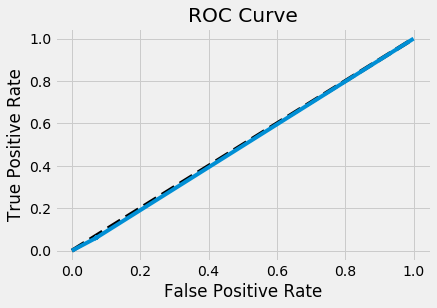

In [105]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = MLP.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">6- AdaBoost </h1>

In [106]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=10, random_state=0))
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [107]:
y_pred_ada = ada.predict(X_test)

In [108]:
acc_ada= accuracy_score(y_test, y_pred_ada)
acc_ada

0.9183666832874455

In [109]:
precision_ada = precision_score(y_test,y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)

# f_mesure
F_ada = 2 * (precision_ada * recall_ada) / (precision_ada + recall_ada)
F_ada

0.07764849969381506

In [110]:
roc_auc_score(y_test, y_pred_ada)

0.518817738070446

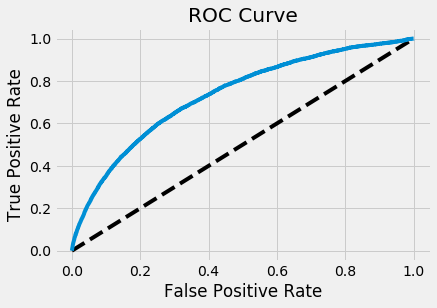

In [111]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = ada.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">7- Gradient Boosting</h1>

In [112]:
gbrt = GradientBoostingClassifier(max_depth=5, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [113]:
y_pred_gbrt = gbrt.predict(X_test)

In [114]:
acc_gbrt= accuracy_score(y_test, y_pred_gbrt)
acc_gbrt

0.9092939059552974

In [115]:
precision_gbrt = precision_score(y_test,y_pred_gbrt)
recall_gbrt = recall_score(y_test, y_pred_gbrt)

# f_mesure
F_gbrt = 2 * (precision_gbrt * recall_gbrt) / (precision_gbrt + recall_gbrt)
F_gbrt

0.10521813515825491

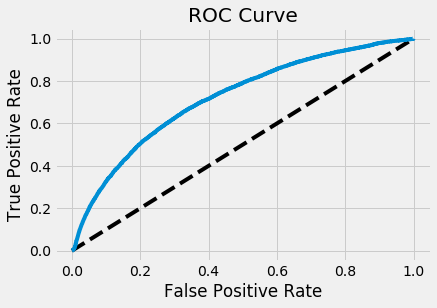

In [116]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = gbrt.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">8- XGBoost </h1>

In [117]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [118]:
y_predXGB = xgb.predict(X_test)
y_predXGB

array([0., 0., 0., ..., 0., 0., 0.])

In [119]:
acc_XGB= accuracy_score(y_test, y_predXGB)
acc_XGB

0.9197866759164914

In [120]:
precision_XGB = precision_score(y_test,y_predXGB)
recall_XGB = recall_score(y_test, y_predXGB)

# f_mesure
F_XGB = 2 * (precision_XGB * recall_XGB) / (precision_XGB + recall_XGB)
F_XGB

0.007776883883078573

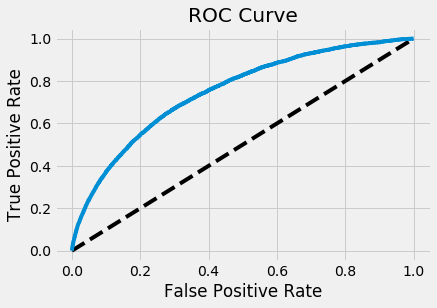

In [121]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = xgb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">9- RandomForest </h1>

In [122]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [123]:
y_predRF = RF.predict(X_test)
y_predRF

array([0., 0., 0., ..., 0., 0., 0.])

In [124]:
acc_RF= accuracy_score(y_test, y_predRF)
acc_RF

0.9188761462917597

In [125]:
precision_RF = precision_score(y_test,y_predRF)
recall_RF = recall_score(y_test, y_predRF)

# f_mesure
F_RF = 2 * (precision_RF * recall_RF) / (precision_RF + recall_RF)
F_RF

0.013445821249670448

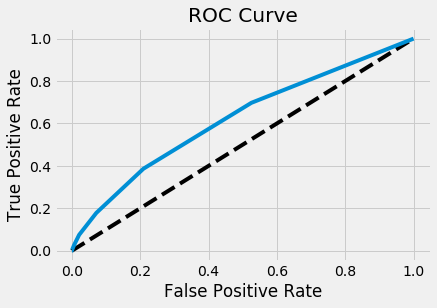

In [126]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = RF.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

[](http://)<h1 style="color:green;">10- BaggingClassifier </h1>

In [127]:
BG = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=10, random_state=0), 
    random_state=42)
BG.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [128]:
y_predBG= BG.predict(X_test)
y_predBG

array([0., 0., 0., ..., 0., 0., 0.])

In [129]:
acc_BG= accuracy_score(y_test, y_predBG)
acc_BG

0.9196457606174258

In [130]:
precision_BG = precision_score(y_test,y_predBG)
recall_BG = recall_score(y_test, y_predBG)

# f_mesure
F_BG = 2 * (precision_BG * recall_BG) / (precision_BG + recall_BG)
F_BG

nan

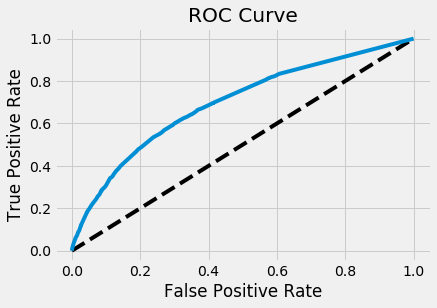

In [131]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = BG.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">11- Voting classifier </h1>


In [132]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
voting = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Ran...andom_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [133]:
y_predVoting = voting.predict(X_test)
y_predVoting

array([0., 0., 0., ..., 0., 0., 0.])

In [134]:
acc_Voting= accuracy_score(y_test, y_predVoting)
acc_Voting

0.9196457606174258

In [135]:
precision_Voting = precision_score(y_test,y_predVoting)
recall_Voting = recall_score(y_test, y_predVoting)

# f_mesure
F_Voting = 2 * (precision_Voting * recall_Voting) / (precision_Voting + recall_Voting)
F_Voting

nan

<h1 style="color:green;">12- Stacking Classifier </h1>


In [136]:
stacking = StackingClassifier(classifiers=[knn, RF], 
                          meta_classifier=LogisticRegression())

print('3-fold cross validation:\n')

for clf, label in zip([knn, RF, stacking], 
                      ['KNN', 
                       'Random Forest', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train,cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.90 (+/- 0.00) [KNN]
Accuracy: 0.92 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.00) [StackingClassifier]


In [137]:
stacking.fit(X_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='a...imators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [138]:
y_predstacking = stacking.predict(X_test)
y_predstacking

array([0., 0., 0., ..., 0., 0., 0.])

In [139]:
acc_stacking= accuracy_score(y_test, y_predstacking)
acc_stacking

0.9188761462917597

In [140]:
precision_stacking = precision_score(y_test,y_predstacking)
recall_stacking = recall_score(y_test, y_predstacking)

# f_mesure
F_stacking = 2 * (precision_stacking * recall_stacking) / (precision_stacking + recall_stacking)
F_stacking

0.013445821249670448

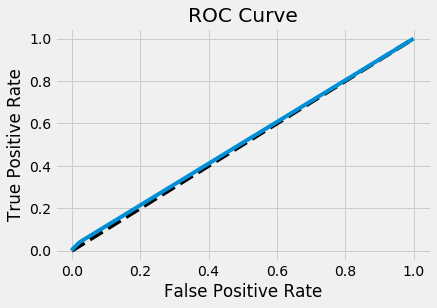

In [141]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = stacking.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<h1 style="color:green;">13- Lasso </h1>


In [142]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)#Lasso(alpha=0.1)

In [143]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [144]:
y_predlasso= lasso.predict(X_test)
y_predlasso

array([0.08088936, 0.08088936, 0.08088936, ..., 0.08088936, 0.08088936,
       0.08088936])

Binariser le "y_predlasso" to 0 ou 1.

In [145]:
y_predlasso = (y_predlasso> 0.7)*1
y_predlasso

array([0, 0, 0, ..., 0, 0, 0])

In [146]:
acc_lasso= accuracy_score(y_test, y_predlasso)
acc_lasso

0.9196457606174258

In [147]:
precision_lasso= precision_score(y_test,y_predlasso)
recall_lasso = recall_score(y_test, y_predlasso)

# f_mesure
F_lasso = 2 * (precision_lasso * recall_lasso) / (precision_lasso + recall_lasso)
F_lasso

nan

In [148]:
# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

[-0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0. -0.
 -0.  0. -0. -0.  0. -0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.
  0. -0. -0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.  0. -0.  0.  0. -0.
  0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0.  0.  0. -0.  0.  0.  0.
 -0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0.
 -0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0.
 -0. -0.  0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0.  0. -0.  0.
 -0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0.
 -0. -0.  0. -0. -0.  0. -0.  0.]


<h1 style="color:green;">14- Deep Learning (ANN)

In [149]:
# Convert the target to categorical: target
target = to_categorical(app_train.TARGET)
#target = y
predictors = X

In [150]:
n_cols = predictors.shape[1]
#Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(10, activation='relu', input_shape=(n_cols,)))

# Add the output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [151]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model.fit(predictors, target, validation_split=0.3, epochs=30, callbacks=[early_stopping_monitor])

Train on 215257 samples, validate on 92254 samples
Epoch 1/30
215257/215257 [==============================] - 13s 60us/step - loss: 1.3100 - acc: 0.9187 - val_loss: 1.2814 - val_acc: 0.9205
Epoch 2/30
215257/215257 [==============================] - 13s 58us/step - loss: 1.3097 - acc: 0.9187 - val_loss: 1.2814 - val_acc: 0.9205
Epoch 3/30
215257/215257 [==============================] - 13s 58us/step - loss: 1.3097 - acc: 0.9187 - val_loss: 1.2814 - val_acc: 0.9205


<h3 style="color:green">Comparaison des algorithmes avant feature selection.  

In [152]:
dataframe=pd.DataFrame({'Modele': ['Lasso','DecisionTree','KNN','K-Centroide','ANN','Stacking','Ridge','AdaBoot','BaggingClassifier','xgBoot','GradientBoosting','RandomForest','MLP Classifier','VotingClassifier'], 
            'Accuracy' : [acc_lasso,acc_DT,acc_knn,acc_KC,0.0813,acc_stacking,acc_ridge,acc_ada,acc_BG,acc_XGB,acc_gbrt,acc_RF,acc_MLP, acc_Voting],
            'Precision' : [precision_lasso,precision_DT,precision_knn,precision_KC,0,precision_stacking,precision_ridge,precision_ada,precision_BG,precision_XGB,precision_gbrt,precision_RF,precision_MLP, precision_Voting],
            'Recall' : [recall_lasso,recall_DT,recall_knn,recall_KC,0,recall_stacking,recall_ridge,recall_ada,recall_BG,recall_XGB,recall_gbrt,recall_RF,recall_MLP, recall_Voting],
            'F-mesure' : [F_lasso,F_DT,F_knn,F_KC,'NaN',F_stacking,F_ridge,F_ada,F_BG,F_XGB,F_gbrt,F_RF,F_MLP, F_Voting]})
dataframe

,Modele,Accuracy,Precision,Recall,F-mesure
0,Lasso,0.919646,0.000000,0.000000,NaN
1,DecisionTree,0.919646,0.000000,0.000000,NaN
2,KNN,0.902682,0.120698,0.033590,0.0525538
3,K-Centroide,0.427060,0.088863,0.662485,0.156706
4,ANN,0.081300,0.000000,0.000000,NaN
5,Stacking,0.918876,0.294798,0.006880,0.0134458
6,Ridge,0.919657,1.000000,0.000135,0.00026976
7,AdaBoot,0.918367,0.421543,0.042763,0.0776485
8,BaggingClassifier,0.919646,0.000000,0.000000,NaN
9,xgBoot,0.919787,0.644444,0.003912,0.00777688


In [153]:
df2 = pd.DataFrame(dataframe)
# Trier le  dataframe
meanplot1 = df2.sort_values('Accuracy', ascending=False)

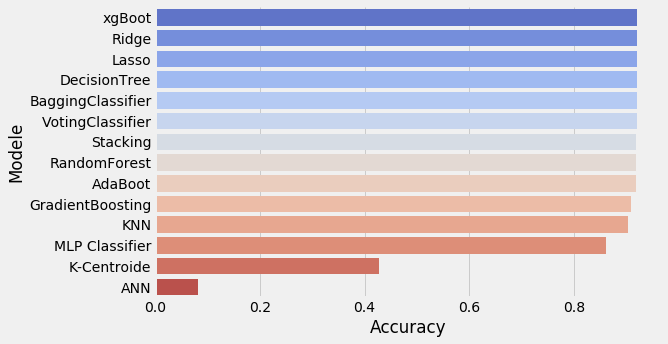

In [154]:
sns.factorplot(x="Accuracy", y="Modele", data = meanplot1, kind="bar", size=5, aspect=1.9, palette='coolwarm')

<h1 style="color:red">Submission

In [155]:
y_prdXGB = xgbt.predict_proba(app_test)[:,1]

In [156]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = y_prdXGB

In [157]:
submit.to_csv("Fethelkhair_AitJilal_1.csv", index=False)

<h2 style="color:red">Features Exploration and Engineering</h2>


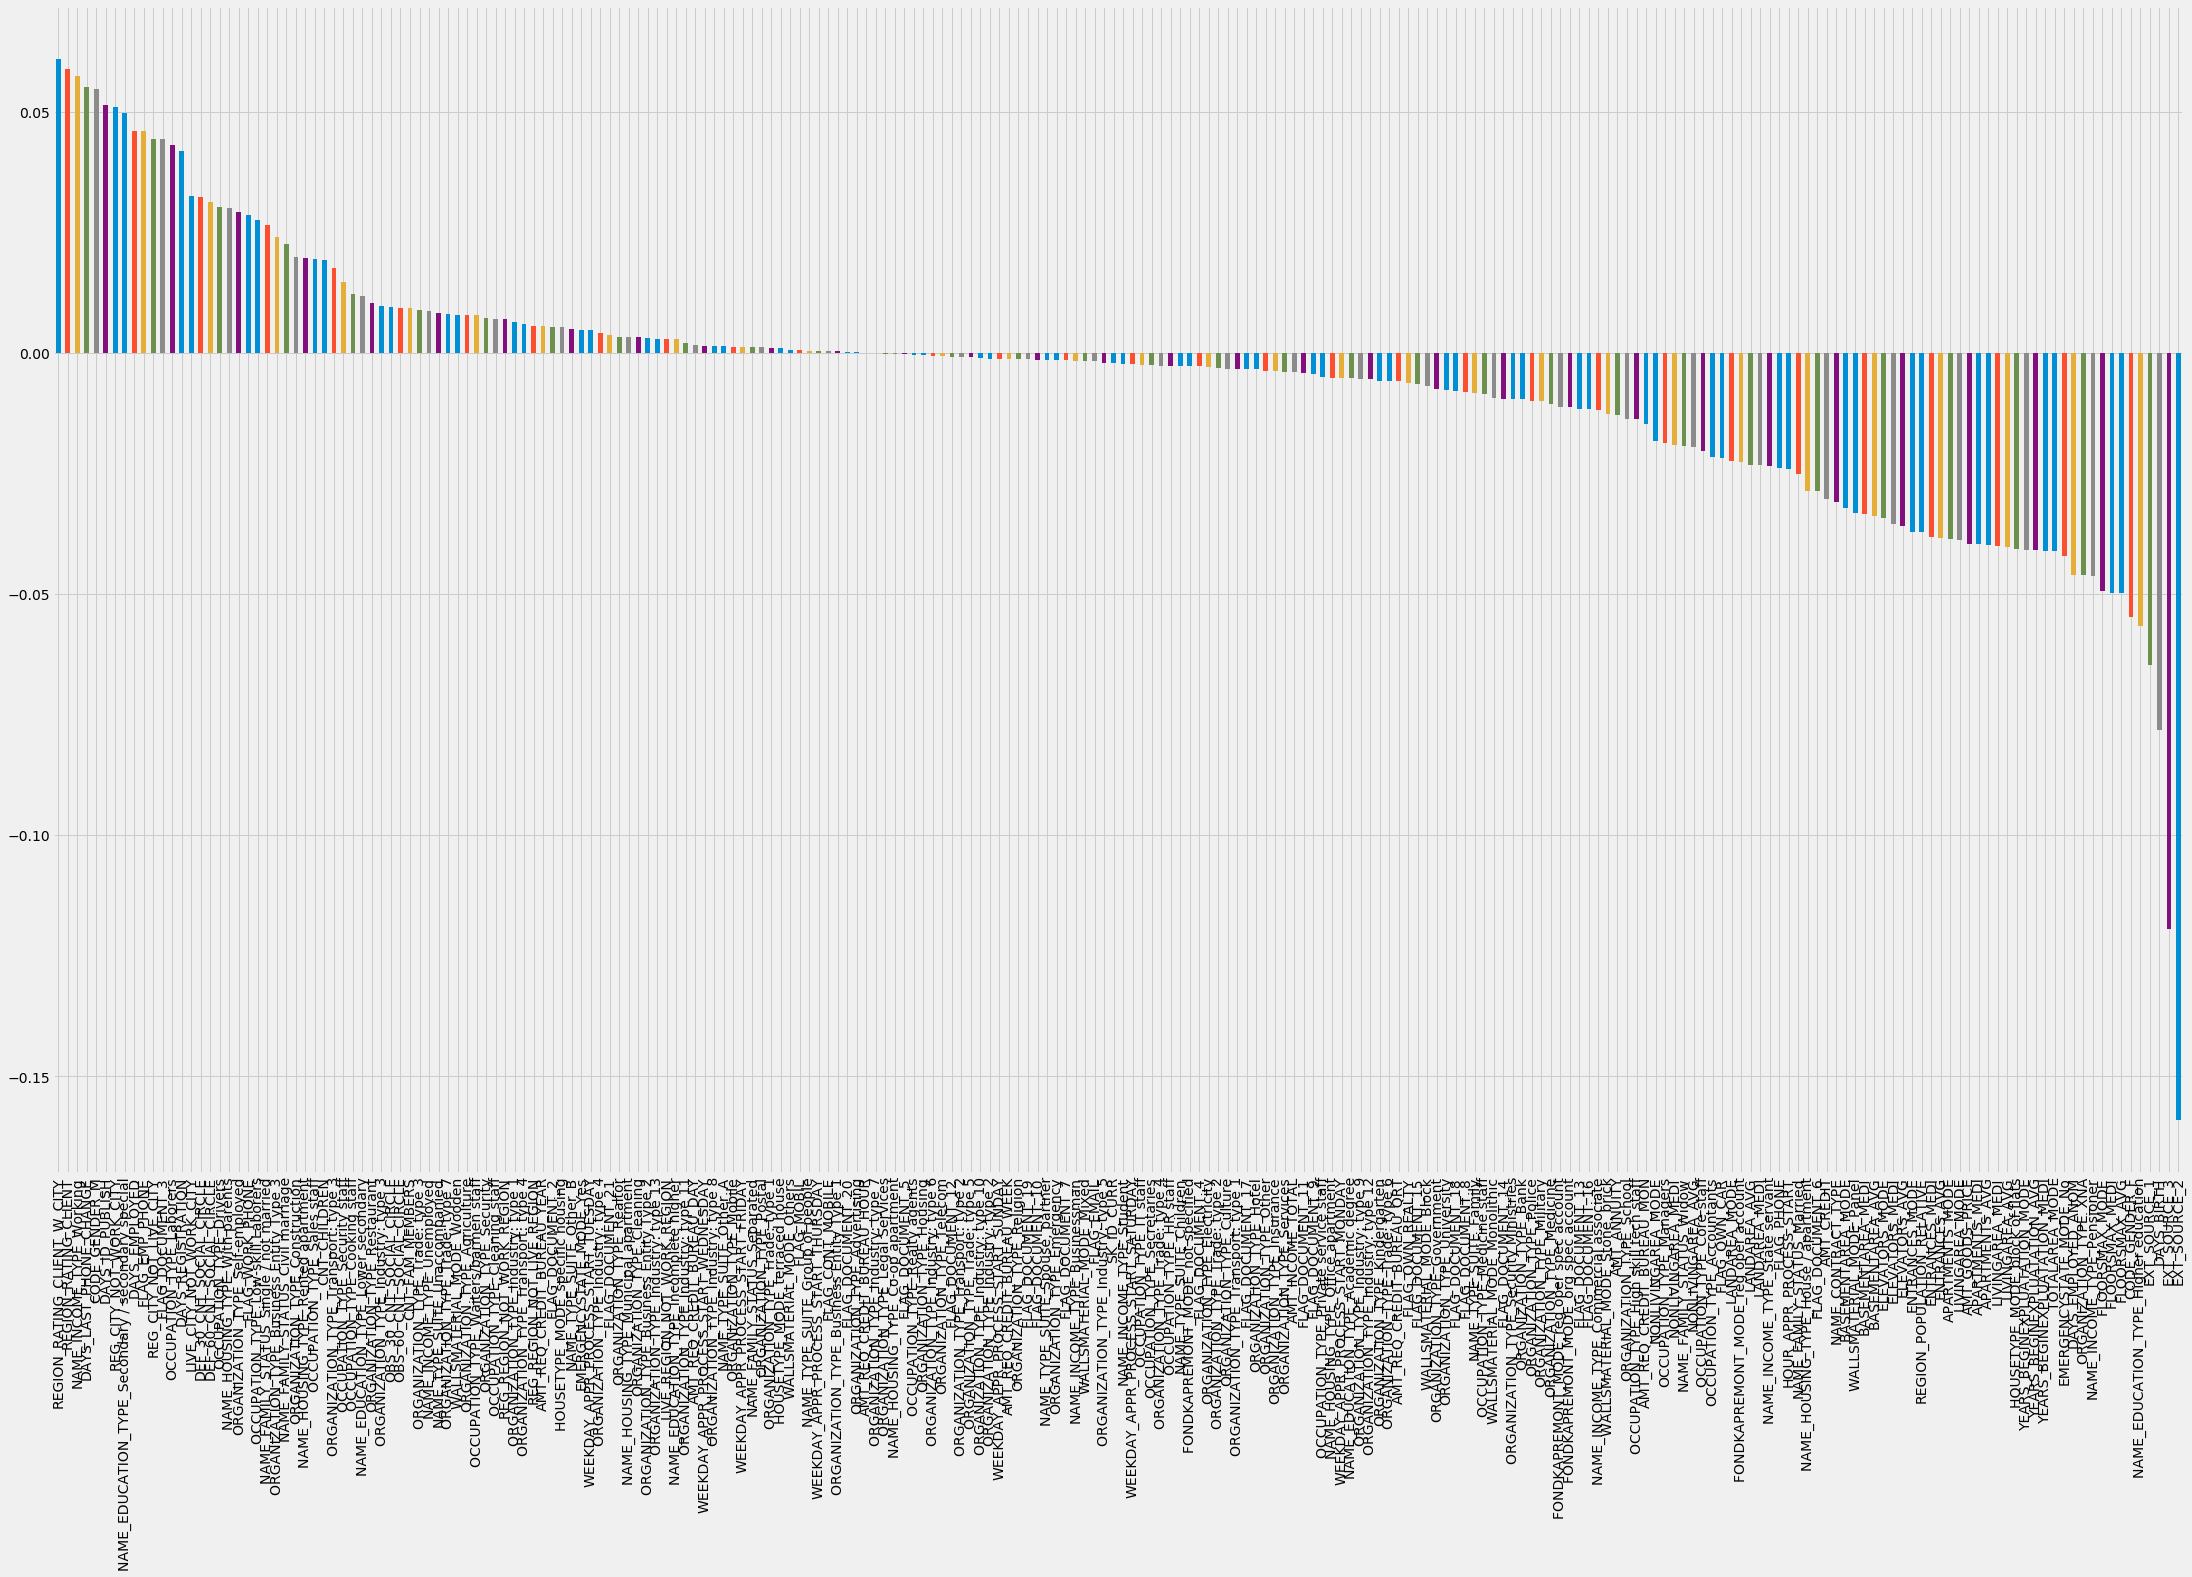

In [158]:
corr_with_target = app_train.corr()["TARGET"].sort_values(ascending=False)
plt.figure(figsize=(34,20))
corr_with_target.drop("TARGET").plot.bar()
plt.show()

REGION_POPULATION_RELATIVE, REGION_RATING_CLIENT, EXT_SOURCE_1, EXT_SOURCE_2,EXT_SOURCE_3, sont trop corrélés avec la cible 'TARGET', ça veut dire que la prédiction de la cible depend étroitement des caractéristiques bien corrélées avec elle. Nous allons procéder à visialiser la dépendance entre quelues caractéristiques. 

####  Nous allons procéder maintenant à une analyse approfondie pour extraire les caractéristiques importantes.

In [159]:
# définir un dictionnaire pour stocker nos rankings 
ranks = {}
# créer une fonction qui stocke le classement des caractéristiques 
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [160]:
from sklearn.preprocessing import MinMaxScaler

#supprimer la colonne cible 
df=app_train.drop(['TARGET'],axis=1)
#stocker les features dans une liste de featurs
colnames=df.columns

rf = RandomForestClassifier(n_jobs=-1, n_estimators=50, verbose=0)
rf.fit(X_train, y_train)
ranks["Random Forest"] = ranking(rf.feature_importances_, colnames)

In [161]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=30), learning_rate=0.5, random_state=42)
ada.fit(X_train, y_train)
ranks["Adaboost"] = ranking(ada.feature_importances_, colnames)

In [162]:
gb = GradientBoostingClassifier(max_depth=5, learning_rate=1.0, random_state=42)
gb.fit(X_train, y_train)
ranks["GradientBoost"] = ranking(gb.feature_importances_, colnames)

In [163]:
# créer un dictionnaire vide pour contenir la valeur moyenne des scores calculés 
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, [ranks[method][name] for method in methods]))))

	Adaboost	GradientBoost	Random Forest	Mean
SK_ID_CURR	0.08	0.09	0.65	0.27
NAME_CONTRACT_TYPE	0.0	0.01	0.04	0.02
FLAG_OWN_CAR	0.01	0.01	0.1	0.04
FLAG_OWN_REALTY	0.01	0.0	0.11	0.04
CNT_CHILDREN	0.01	0.02	0.15	0.06
AMT_INCOME_TOTAL	0.04	0.05	0.51	0.2
AMT_CREDIT	0.05	0.08	0.58	0.24
AMT_ANNUITY	1.0	0.12	0.61	0.58
AMT_GOODS_PRICE	0.02	0.07	0.5	0.2
REGION_POPULATION_RELATIVE	0.04	0.05	0.51	0.2
DAYS_BIRTH	0.05	0.23	0.67	0.32
DAYS_EMPLOYED	0.07	0.08	0.59	0.25
DAYS_REGISTRATION	nan	0.1	0.66	nan
DAYS_ID_PUBLISH	0.09	0.1	0.67	0.29
FLAG_MOBIL	0.0	0.0	0.0	0.0
FLAG_EMP_PHONE	0.0	0.0	0.02	0.01
FLAG_WORK_PHONE	0.0	0.01	0.09	0.03
FLAG_CONT_MOBILE	0.0	0.0	0.0	0.0
FLAG_PHONE	0.01	0.0	0.1	0.04
FLAG_EMAIL	0.0	0.0	0.05	0.02
CNT_FAM_MEMBERS	0.05	0.01	0.21	0.09
REGION_RATING_CLIENT	0.01	0.01	0.1	0.04
REGION_RATING_CLIENT_W_CITY	0.01	0.01	0.1	0.04
HOUR_APPR_PROCESS_START	0.05	0.04	0.45	0.18
REG_REGION_NOT_LIVE_REGION	0.0	0.0	0.02	0.01
REG_REGION_NOT_WORK_REGION	0.0	0.0	0.04	0.01
LIVE_REGION_NOT_WORK_REGION	0.0	

# Merging data

**SK_ID_CURR** connecte les dataframes de données *application_train|test* avec *bureau*, *previous_application* et également avec les dataframes de données *POS_CASH_balance*, *installments_payment* et *credit_card_balance*. **SK_ID_PREV** connecte la base de données *previous_application* à *POS_CASH_balance*, *installments_payment* et *credit_card_balance*. **SK_ID_BUREAU** connecte le dataframe bureau aux données du *bureau_balance*.

###  - Merge training data

In [164]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [165]:
# Join to the training dataframe
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,previous_loan_counts
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,8.0
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765.0,-1188.0,-1186.0,-291.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311267,0.622246,0.000000,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,19046.0,-225.0,-4260.0,-2531.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.555912,0.729567,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,19005.0,-3039.0,-9833.0,-2437.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.650442,0.000000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,19932.0,-3038.0,-4311.0,-3458.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.322738,0.000000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


###  - Merge test data

In [166]:
# Join to the training dataframe
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
app_test['previous_loan_counts'] = app_test['previous_loan_counts'].fillna(0)
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,previous_loan_counts
0,100001.0,0.0,0.0,1.0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,-2329.0,-5170.0,-812.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,0.00,0.1379,0.125,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0
1,100005.0,0.0,0.0,1.0,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.564990,0.291656,0.432962,0.0000,0.0000,0.0000,0.00,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.699787,0.610991,0.0000,0.0000,0.0000,0.00,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,100028.0,0.0,0.0,1.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.32,0.2759,0.375,0.2042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,12.0
4,100038.0,0.0,1.0,0.0,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.202145,0.425687,0.000000,0.0000,0.0000,0.0000,0.00,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1196
Median value for loan that was not repaid = 0.2881
Median value for loan that was repaid =     0.4741


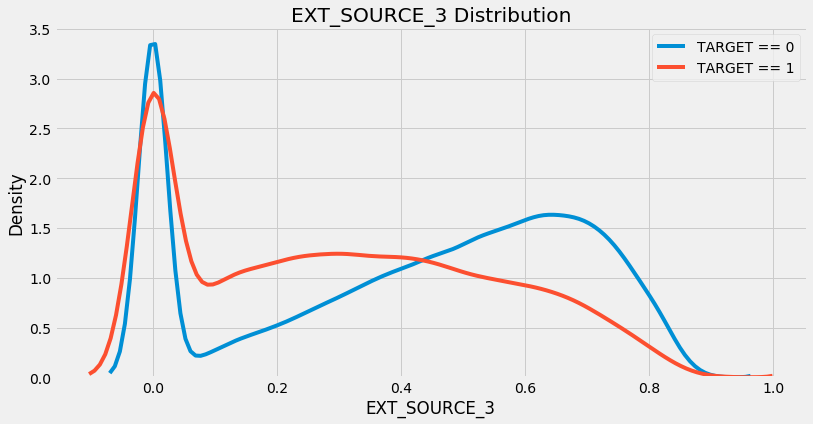

In [168]:
kde_target('EXT_SOURCE_3', app_train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


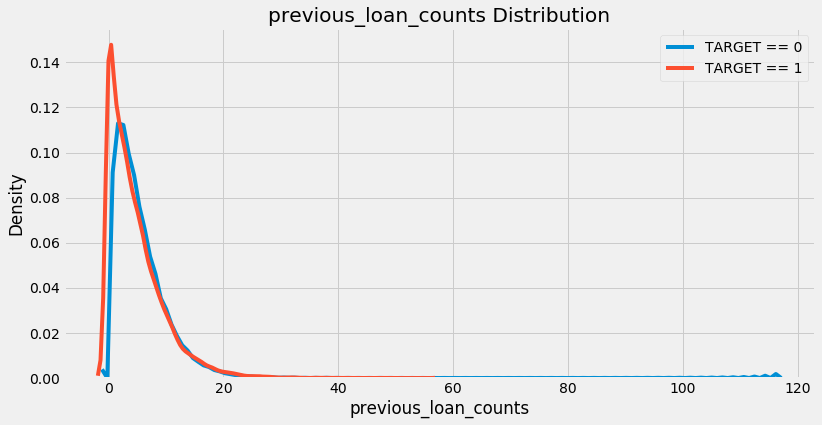

In [169]:
kde_target('previous_loan_counts', app_train)

Maintenant, on va sélectionné les attributs les plus significatifs
pour les utiliser par la suite pour appliquer de nouveau les
algorithmes. 

In [170]:
# mettre la moyenne dans un dataframe Pandas
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Trier le  dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

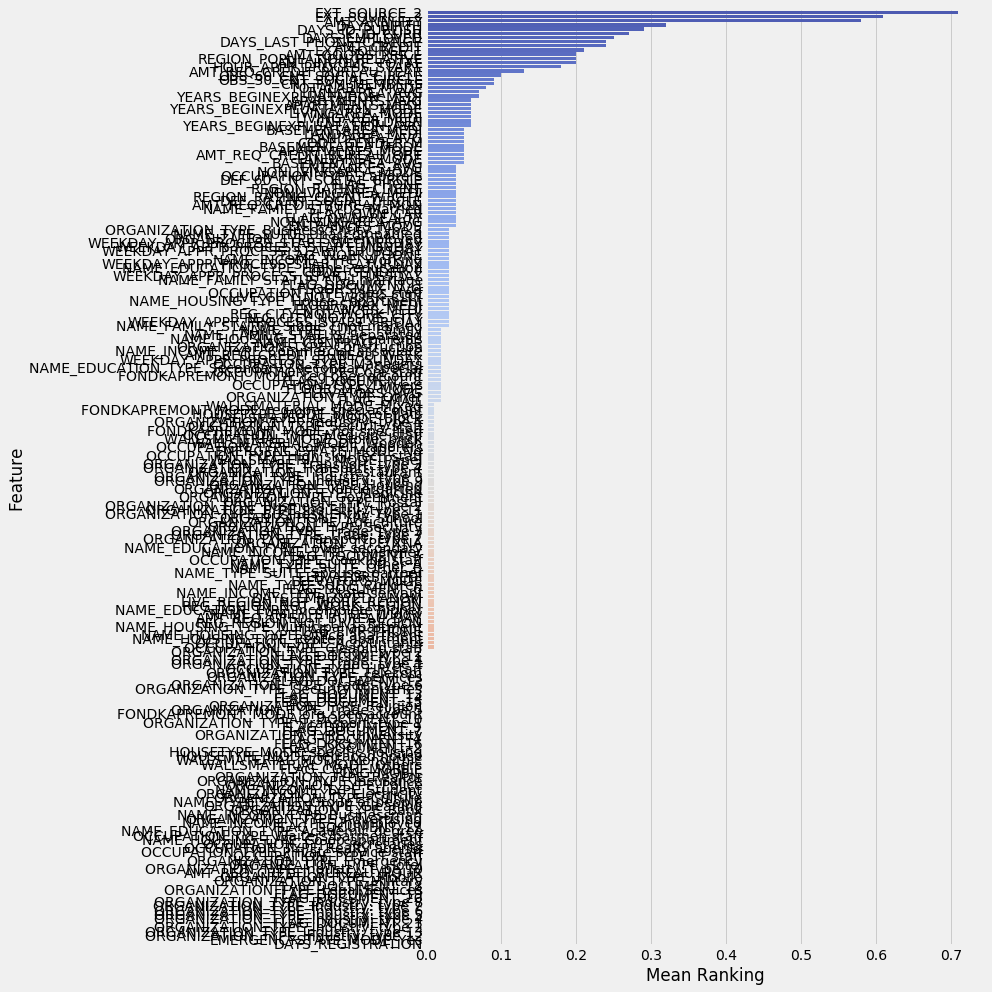

In [171]:
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", size=14, aspect=1, palette='coolwarm')

In [172]:
meanplot.count()

Feature         224
Mean Ranking    223
dtype: int64

Nous allons utilisées les 50 caractéristiques les plus importantes.

In [173]:
features_import=meanplot.head(50)['Feature']

In [174]:
features_import

31                     EXT_SOURCE_2
32                     EXT_SOURCE_3
7                       AMT_ANNUITY
10                       DAYS_BIRTH
13                  DAYS_ID_PUBLISH
0                        SK_ID_CURR
11                    DAYS_EMPLOYED
65           DAYS_LAST_PHONE_CHANGE
6                        AMT_CREDIT
30                     EXT_SOURCE_1
8                   AMT_GOODS_PRICE
9        REGION_POPULATION_RELATIVE
5                  AMT_INCOME_TOTAL
23          HOUR_APPR_PROCESS_START
91       AMT_REQ_CREDIT_BUREAU_YEAR
63         OBS_60_CNT_SOCIAL_CIRCLE
61         OBS_30_CNT_SOCIAL_CIRCLE
20                  CNT_FAM_MEMBERS
60                   TOTALAREA_MODE
40                   LIVINGAREA_AVG
53     YEARS_BEGINEXPLUATATION_MEDI
33                   APARTMENTS_AVG
51                  APARTMENTS_MEDI
44     YEARS_BEGINEXPLUATATION_MODE
49                  LIVINGAREA_MODE
58                  LIVINGAREA_MEDI
4                      CNT_CHILDREN
35      YEARS_BEGINEXPLUATAT

<h1 style="color:red">Application des algorithmes avec fautures engineering

## Préparation des données

#### Alignement de données de Training et de Test

In [175]:
# On stock la colonne TARGET dans la variable train_labels
train_labels = app_train['TARGET']

# On aligne les données de training et de test , On garde que els colonnes présentent dans les deux dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 226)
Testing Features shape:  (48744, 225)


In [176]:
X = app_train[features_import]
X.shape

(307511, 50)

In [177]:
y = app_train["TARGET"]
y.shape

(307511,)

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h1 style="color:green;">1- K-Nearest Neighbors (K-NN)  </h1>

In [179]:
#create KNN classifier object by passing argument number of neighbors in KNeighborsClassifier() function.
knn = nb.KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [180]:
y_predKnn = knn.predict(X_test)
y_predKnn 

array([0., 0., 1., ..., 0., 0., 0.])

In [181]:
acc_knn = accuracy_score(y_test, y_predKnn)
print("Accuracy:", acc_knn)

Accuracy: 0.9024215752162508


In [182]:
precision_knn= precision_score(y_test,y_predKnn)
recall_knn = recall_score(y_test, y_predKnn)

# f_mesure
F_knn = 2 * (precision_knn* recall_knn) / (precision_knn + recall_knn)
F_knn

0.05162241887905605

<h1 style="color:green;"> 2- DecisionTreeClassifier 

In [183]:
xgbT = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
xgbT .fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [184]:
y_predDT = xgbT .predict(X_test)
y_predDT

array([0., 0., 0., ..., 0., 0., 0.])

In [185]:
acc_DT = accuracy_score(y_test, y_predDT)
acc_DT

0.9196457606174258

In [186]:
precision_DT = precision_score(y_test,y_predDT)
recall_DT = recall_score(y_test, y_predDT)

# f_mesure
F_DT = 2 * (precision_DT * recall_DT) / (precision_DT + recall_DT)
F_DT

nan

In [187]:
roc_auc_score(y_test, y_predDT)

0.5

<h1 style="color:green;">3- K-centroide</h1>

In [188]:
model_centroide = NearestCentroid()
model_centroide.fit(X_train, y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [189]:
y_predCentroide=model_centroide.predict(X_test)
y_predCentroide

array([1., 0., 1., ..., 1., 1., 1.])

In [190]:
acc_KC = accuracy_score(y_test, y_predCentroide)
acc_KC

0.42704923363756586

In [191]:
precision_KC = precision_score(y_test,y_predCentroide)
recall_KC = recall_score(y_test, y_predCentroide)

# f_mesure
F_KC = 2 * (precision_KC * recall_KC) / (precision_KC + recall_KC)
F_KC

0.1567032020293878

In [192]:
roc_auc_score(y_test, y_predCentroide)

0.5344814119907426

<h1 style="color:green;">4- Ridge  </h1>

In [193]:
ridge = RidgeClassifier(alpha=41, max_iter=50000)
ridge.fit(X_train, y_train)

RidgeClassifier(alpha=41, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=50000, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [194]:
y_predridge = ridge.predict(X_test)
y_predridge

array([0., 0., 0., ..., 0., 0., 0.])

In [195]:
acc_ridge= accuracy_score(y_test, y_predridge)
acc_ridge

0.9196457606174258

In [196]:
precision_ridge = precision_score(y_test,y_predridge)
recall_ridge = recall_score(y_test, y_predridge)

# f_mesure
F_ridge = 2 * (precision_ridge * recall_ridge) / (precision_ridge + recall_ridge)
F_ridge

nan

In [197]:
roc_auc_score(y_test, y_predridge)

0.5

<h1 style="color:green;">5- Neural Network: MLPClassifier </h1>

In [198]:
# MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
MLP.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [199]:
y_predMLP = MLP.predict(X_test)
y_predMLP

array([1., 1., 1., ..., 1., 1., 1.])

In [200]:
acc_MLP= accuracy_score(y_test, y_predMLP)
acc_MLP

0.09960543716261626

In [201]:
precision_MLP = precision_score(y_test,y_predMLP)
recall_MLP = recall_score(y_test, y_predMLP)

# f_mesure
F_MLP = 2 * (precision_MLP * recall_MLP) / (precision_MLP + recall_MLP)
F_MLP

0.1481648600699394

<h1 style="color:green;">6- AdaBoost </h1>

In [202]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=10, random_state=0))
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [203]:
y_pred_ada = ada.predict(X_test)

In [204]:
acc_ada= accuracy_score(y_test, y_pred_ada)
acc_ada

0.9187894291846423

In [205]:
precision_ada = precision_score(y_test,y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)

# f_mesure
F_ada = 2 * (precision_ada * recall_ada) / (precision_ada + recall_ada)
F_ada

0.07414730598121602

In [206]:
roc_auc_score(y_test, y_pred_ada)

0.5180011328926181

<h1 style="color:green;">7- Gradient Boosting</h1>

In [207]:
gbrt = GradientBoostingClassifier(max_depth=5, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [208]:
y_pred_gbrt = gbrt.predict(X_test)

In [209]:
acc_gbrt= accuracy_score(y_test, y_pred_gbrt)
acc_gbrt

0.909402302339194

In [210]:
precision_gbrt = precision_score(y_test,y_pred_gbrt)
recall_gbrt = recall_score(y_test, y_pred_gbrt)

# f_mesure
F_gbrt = 2 * (precision_gbrt * recall_gbrt) / (precision_gbrt + recall_gbrt)
F_gbrt

0.10876519513755598

<h1 style="color:green;">8- XGBoost </h1>

In [211]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [212]:
y_predXGB = xgb.predict(X_test)
y_predXGB

array([0., 0., 0., ..., 0., 0., 0.])

In [213]:
acc_XGB= accuracy_score(y_test, y_predXGB)
acc_XGB

0.9196999588093742

In [214]:
precision_XGB = precision_score(y_test,y_predXGB)
recall_XGB = recall_score(y_test, y_predXGB)

# f_mesure
F_XGB = 2 * (precision_XGB * recall_XGB) / (precision_XGB + recall_XGB)
F_XGB

0.006437768240343348

<h1 style="color:green;">9- RandomForest </h1>

In [215]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [216]:
y_predRF = RF.predict(X_test)
y_predRF

array([0., 0., 0., ..., 0., 0., 0.])

In [217]:
acc_RF= accuracy_score(y_test, y_predRF)
acc_RF

0.9185184382249009

In [218]:
precision_RF = precision_score(y_test,y_predRF)
recall_RF = recall_score(y_test, y_predRF)

# f_mesure
F_RF = 2 * (precision_RF * recall_RF) / (precision_RF + recall_RF)
F_RF

0.02338573470183188

[](http://)<h1 style="color:green;">10- BaggingClassifier </h1>

In [219]:
BG = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=10, random_state=0), 
    random_state=42)
BG.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [220]:
y_predBG= BG.predict(X_test)
y_predBG

array([0., 0., 0., ..., 0., 0., 0.])

In [221]:
acc_BG= accuracy_score(y_test, y_predBG)
acc_BG

0.9196457606174258

In [222]:
precision_BG = precision_score(y_test,y_predBG)
recall_BG = recall_score(y_test, y_predBG)

# f_mesure
F_BG = 2 * (precision_BG * recall_BG) / (precision_BG + recall_BG)
F_BG

nan

<h1 style="color:green;">11- Voting classifier </h1>


In [223]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
voting = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Ran...andom_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [224]:
y_predVoting = voting.predict(X_test)
y_predVoting

array([0., 0., 0., ..., 0., 0., 0.])

In [225]:
acc_Voting= accuracy_score(y_test, y_predVoting)
acc_Voting

0.9196457606174258

In [226]:
precision_Voting = precision_score(y_test,y_predVoting)
recall_Voting = recall_score(y_test, y_predVoting)

# f_mesure
F_Voting = 2 * (precision_Voting * recall_Voting) / (precision_Voting + recall_Voting)
F_Voting

nan

In [227]:
# leur prédiction est la même presque dans tous les cas 
np.abs(np.sum(y_predRF - y_predVoting) / len(y_predRF))

0.0030784573026643833

<h1 style="color:green;">12- Stacking Classifier </h1>


In [228]:
stacking = StackingClassifier(classifiers=[knn, RF], 
                          meta_classifier=LogisticRegression())

print('3-fold cross validation:\n')

for clf, label in zip([knn, RF, stacking], 
                      ['KNN', 
                       'Random Forest', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train,cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.90 (+/- 0.00) [KNN]
Accuracy: 0.92 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.00) [StackingClassifier]


In [229]:
stacking.fit(X_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='a...imators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [230]:
y_predstacking = stacking.predict(X_test)
y_predstacking

array([0., 0., 0., ..., 0., 0., 0.])

In [231]:
acc_stacking= accuracy_score(y_test, y_predstacking)
acc_stacking

0.9185184382249009

In [232]:
precision_stacking = precision_score(y_test,y_predstacking)
recall_stacking = recall_score(y_test, y_predstacking)

# f_mesure
F_stacking = 2 * (precision_stacking * recall_stacking) / (precision_stacking + recall_stacking)
F_stacking

0.02338573470183188

<h1 style="color:green;">13- Lasso </h1>


In [233]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)#Lasso(alpha=0.1)

In [234]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [235]:
y_predlasso= lasso.predict(X_test)
y_predlasso

array([0.08088936, 0.08088936, 0.08088936, ..., 0.08088936, 0.08088936,
       0.08088936])

Binariser le "y_predlasso" to 0 ou 1.

In [236]:
y_predlasso = (y_predlasso> 0.7)*1
y_predlasso

array([0, 0, 0, ..., 0, 0, 0])

In [237]:
acc_lasso= accuracy_score(y_test, y_predlasso)
acc_lasso

0.9196457606174258

In [238]:
precision_lasso= precision_score(y_test,y_predlasso)
recall_lasso = recall_score(y_test, y_predlasso)

# f_mesure
F_lasso = 2 * (precision_lasso * recall_lasso) / (precision_lasso + recall_lasso)
F_lasso

nan

In [239]:
# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

[-0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0. -0.  0. -0.  0.  0. -0. -0. -0. -0.]


<h1 style="color:green;">14- Deep Learning

In [240]:
# Convert the target to categorical: target
target = to_categorical(app_train.TARGET)
#target = y
predictors = X

In [241]:
n_cols = predictors.shape[1]
#Set up the model
model = Sequential()

# Add the first layer
model.add(Dense(10, activation='relu', input_shape=(n_cols,)))

# Add the output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
acc_ANN = metrics=['accuracy']

In [242]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model.fit(predictors, target, validation_split=0.3, epochs=30, callbacks=[early_stopping_monitor])

Train on 215257 samples, validate on 92254 samples
Epoch 1/30
215257/215257 [==============================] - 9s 42us/step - loss: 14.8084 - acc: 0.0813 - val_loss: 14.8367 - val_acc: 0.0795
Epoch 2/30
215257/215257 [==============================] - 8s 39us/step - loss: 14.8084 - acc: 0.0813 - val_loss: 14.8367 - val_acc: 0.0795
Epoch 3/30
215257/215257 [==============================] - 8s 39us/step - loss: 14.8084 - acc: 0.0813 - val_loss: 14.8367 - val_acc: 0.0795


<h3 style="color:green">Comparaison des algorithmes après feature selection. 

In [243]:
dataframe1=pd.DataFrame({'Modele': ['Lasso','DecisionTree','KNN','K-Centroide','ANN','Stacking','Ridge','AdaBoot','BaggingClassifier','xgBoot','GradientBoosting','RandomForest','MLP Classifier','VotingClassifier'], 
            'Accuracy' : [acc_lasso,acc_DT,acc_knn,acc_KC,0.9187,acc_stacking,acc_ridge,acc_ada,acc_BG,acc_XGB,acc_gbrt,acc_RF,acc_MLP, acc_Voting],
            'Precision' : [precision_lasso,precision_DT,precision_knn,precision_KC,0,precision_stacking,precision_ridge,precision_ada,precision_BG,precision_XGB,precision_gbrt,precision_RF,precision_MLP, precision_Voting],
            'Recall' : [recall_lasso,recall_DT,recall_knn,recall_KC,0,recall_stacking,recall_ridge,recall_ada,recall_BG,recall_XGB,recall_gbrt,recall_RF,recall_MLP, recall_Voting],
            'F-mesure' : [F_lasso,F_DT,F_knn,F_KC,'NaN',F_stacking,F_ridge,F_ada,F_BG,F_XGB,F_gbrt,F_RF,F_MLP, F_Voting]})
dataframe1

,Modele,Accuracy,Precision,Recall,F-mesure
0,Lasso,0.919646,0.000000,0.000000,NaN
1,DecisionTree,0.919646,0.000000,0.000000,NaN
2,KNN,0.902422,0.117845,0.033050,0.0516224
3,K-Centroide,0.427049,0.088861,0.662485,0.156703
4,ANN,0.918700,0.000000,0.000000,NaN
5,Stacking,0.918518,0.316901,0.012141,0.0233857
6,Ridge,0.919646,0.000000,0.000000,NaN
7,AdaBoot,0.918789,0.441826,0.040469,0.0741473
8,BaggingClassifier,0.919646,0.000000,0.000000,NaN
9,xgBoot,0.919700,0.558140,0.003238,0.00643777


In [244]:
df = pd.DataFrame(dataframe1)
# Trier le  dataframe
meanplot1 = df.sort_values('Accuracy', ascending=False)

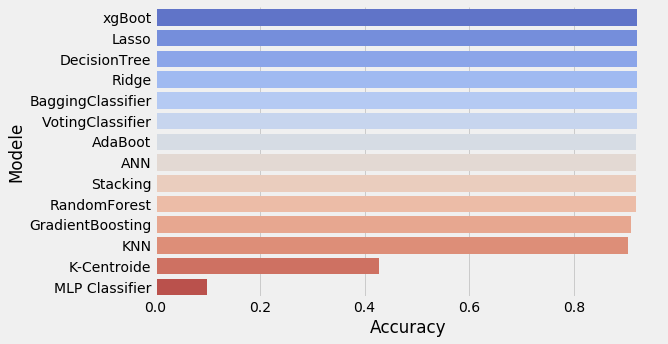

In [245]:
sns.factorplot(x="Accuracy", y="Modele", data = meanplot1, kind="bar", size=5, aspect=1.9, palette='coolwarm')

 ### --> Xgboot donne toujours les meilleurs résultats avec ou sans feature selection. 

<h1 style="color:red">Submission aprés fautures engineering

In [246]:
app_test = app_test[features_import]

In [247]:
y_prdXGBT = xgbT.predict_proba(app_test)[:,1]

In [248]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = y_prdXGBT

In [249]:
submit.to_csv("Fethelkhair_AitJilal_2.csv", index=False)